In [459]:
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
import os
import matplotlib.pyplot as plt
import plotly.express as px
import functools
import seaborn as sns
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [460]:
class CFG:
    data_path = './../data'
    img_dim1 = 20
    img_dim2 = 10
    

plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize': (CFG.img_dim1, CFG.img_dim2)})

# load NSW forecast demand

In [461]:
nsw_forecastdemand = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'forecastdemand_nsw.csv'), 
    parse_dates=['LASTCHANGED', 'DATETIME']
)

In [462]:
# nsw_forecastdemand.head()


- we should try to understand what `periodid` represents
- for now we will `groupby` datetime and use `mean()` as the agg function

In [463]:
nsw_forecastdemand = nsw_forecastdemand.groupby('DATETIME').agg({'FORECASTDEMAND': 'mean'}).reset_index()

- reset the index to datetime

In [464]:
nsw_forecastdemand.set_index('DATETIME', inplace=True)

- do we need any data aside from forecast demand and datetime? I don't see any value in `PREDISPATCHSEQNO`, `REGIONID`, `LASTCHANGED` and of course `PERIODID` disappears

In [465]:
# nsw_forecastdemand.head()

## load NSW actual demand

In [466]:
nsw_totaldemand = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'totaldemand_nsw.csv'), 
    parse_dates=['DATETIME'],
    dayfirst=True,
    index_col='DATETIME',
    usecols=['DATETIME', 'TOTALDEMAND']
)

In [467]:
# nsw_totaldemand.head()

# load NSW temperature

In [468]:
nsw_temperature = pd.read_csv(
    os.path.join(CFG.data_path, 'NSW', 'temperature_nsw.csv'), 
    parse_dates=['DATETIME'], 
    dayfirst=True,
    index_col='DATETIME',
    usecols=['DATETIME', 'TEMPERATURE']
)

In [469]:
# nsw_temperature.head()

# merge

In [470]:
dfs = [nsw_totaldemand, nsw_forecastdemand, nsw_temperature]

In [471]:
nsw_df = functools.reduce(
    lambda left, right: 
    pd.merge(
        left, 
        right, 
        left_index=True, 
        right_index=True, 
        how='inner'
    ), dfs
)

In [472]:
# nsw_df.head()

# EDA

In [473]:
nsw_df.describe()

TOTALDEMAND  FORECASTDEMAND    TEMPERATURE
count  195947.000000   195947.000000  195947.000000
mean     8111.924589     8105.831984      17.530995
std      1299.171401     1302.726720       5.884212
min      5074.630000     4878.596667      -1.300000
25%      7149.430000     7128.798078      13.500000
50%      8052.180000     8060.368868      17.900000
75%      8956.985000     8963.019304      21.500000
max     14579.860000    14601.171964      44.700000

In [474]:
nsw_df.corr()

TOTALDEMAND  FORECASTDEMAND  TEMPERATURE
TOTALDEMAND        1.000000        0.987160     0.149045
FORECASTDEMAND     0.987160        1.000000     0.144881
TEMPERATURE        0.149045        0.144881     1.000000

<Axes: >

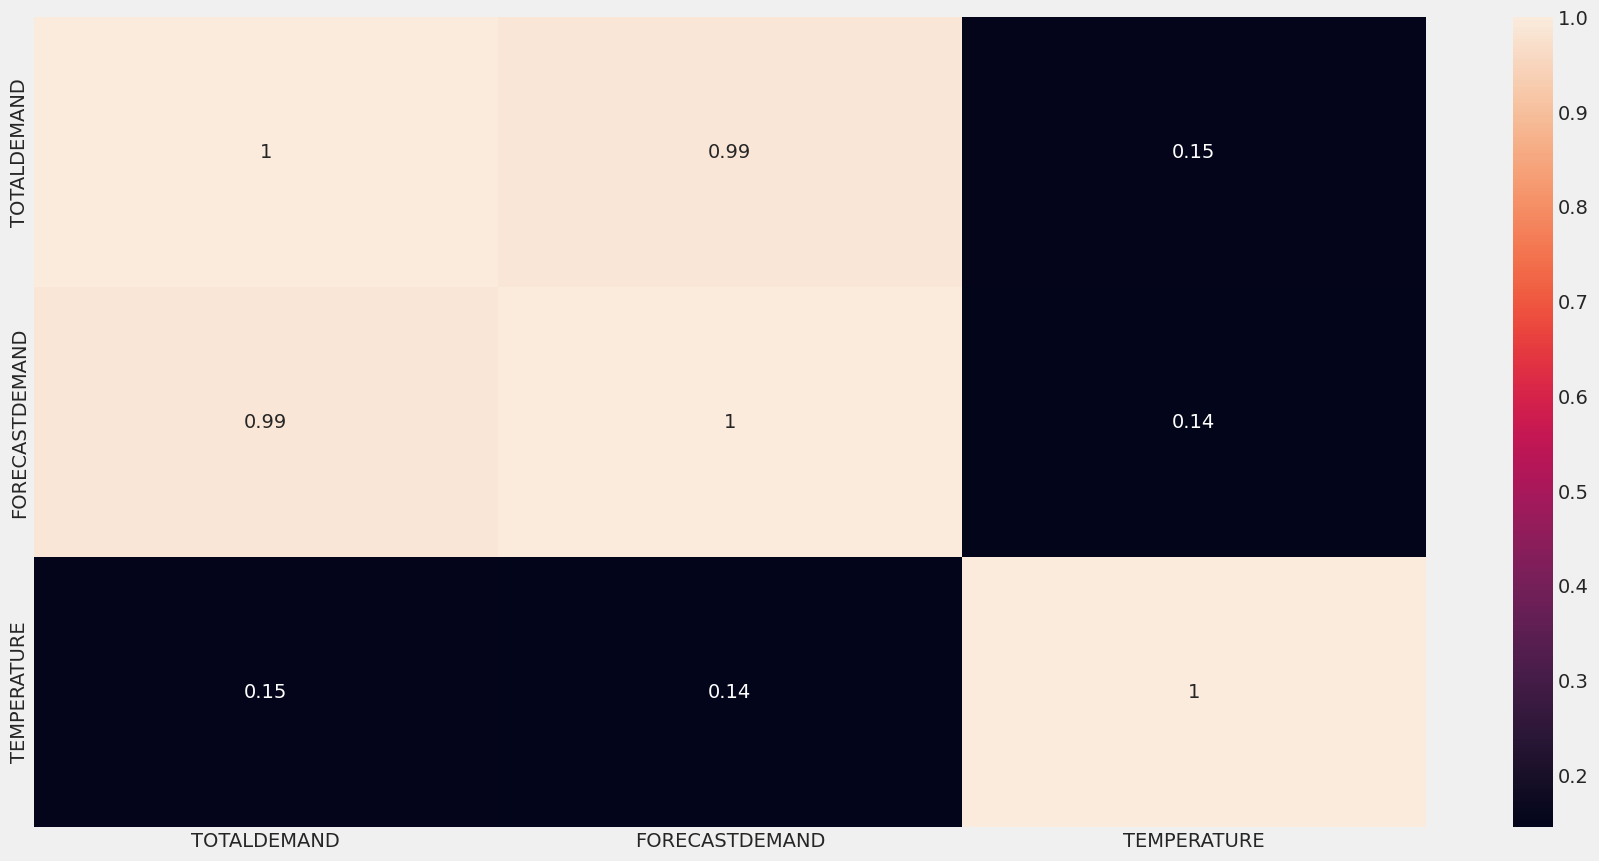

In [475]:
sns.heatmap(nsw_df.corr(), annot=True)

# Forecast and actual demand over time

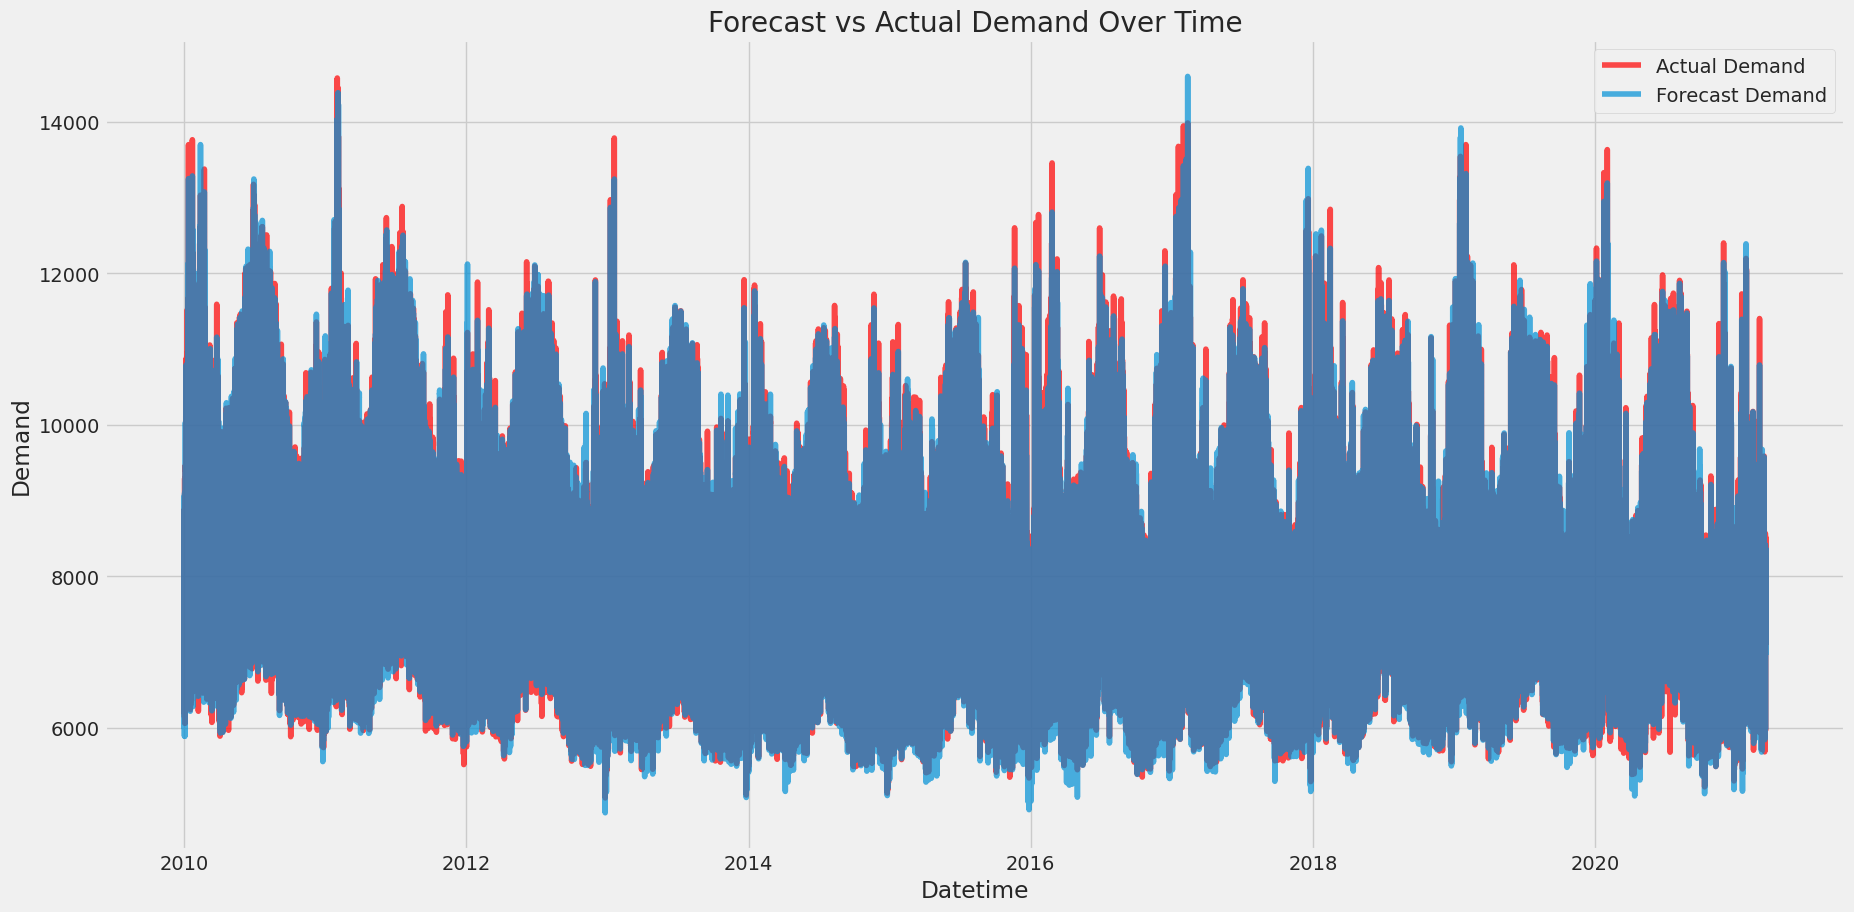

In [476]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.7
)
plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.7
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast vs Actual Demand Over Time')
plt.legend()
plt.show()

# Forecast Demand over time
I've made some changes to try to improve this plot:
- **Smoothing**: The plot is quite noisy, so applying a rolling mean (moving average) can help to smooth out short-term fluctuations and highlight longer-term trends.
- **Highlighting Peaks and Troughs**: You could programmatically identify and annotate significant peaks and troughs to draw attention to them.
- **Resampling**: If the data is too dense, consider resampling it to a larger time frame, such as daily or weekly averages.

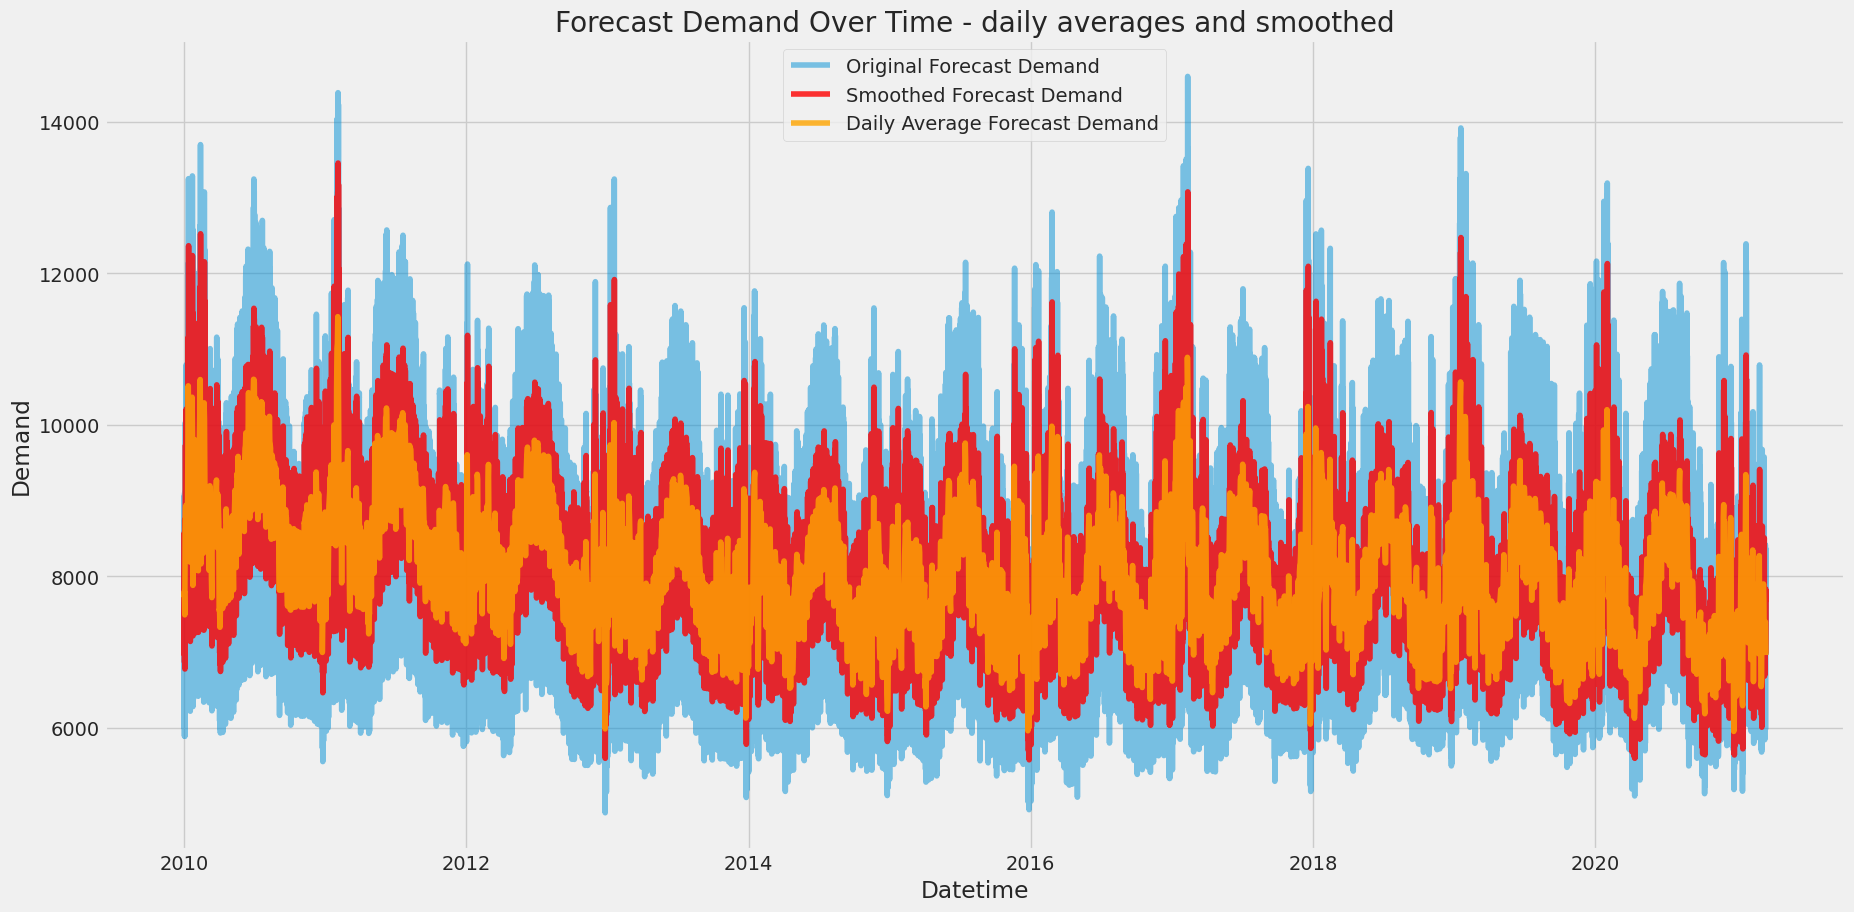

In [494]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
rolling_window = 24
nsw_df['SmoothedForecastDemand'] = nsw_df['FORECASTDEMAND'].rolling(window=rolling_window).mean()
nsw_df_daily = nsw_df['FORECASTDEMAND'].resample('D').mean()

plt.plot(
    nsw_df['FORECASTDEMAND'], 
    label='Original Forecast Demand', 
    alpha=0.5
)

plt.plot(
    nsw_df['SmoothedForecastDemand'], 
    label='Smoothed Forecast Demand', 
    color='red', 
    alpha=0.8
)

plt.plot(nsw_df_daily.index, nsw_df_daily, label='Daily Average Forecast Demand', color='orange', alpha=0.8)

plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Forecast Demand Over Time - daily averages and smoothed')
plt.grid(True)
plt.legend()
plt.show()

## Observations
The plot layers three time series: 
- the original forecast demand, 
- the smoothed forecast demand, 
- and the daily average forecast demand. 

Here are some potential conclusions and observations I draw from this plot:

1. **Volatility**: The original forecast demand shows significant volatility, as indicated by the frequent and sometimes sharp peaks and valleys.

2. **Smoothing Effect**: The smoothed forecast demand (the line in red) has reduced the short-term fluctuations, making the underlying trends more visible. It appears to follow the central tendency of the original forecast, reducing the impact of extreme values.

3. **Daily Patterns**: The daily average forecast demand (the line in yellow) simplifies the data to show the trend within each day, abstracting away the half-hourly variations. This line highlights the overall daily movement in demand without the noise of intra-day fluctuations.

4. **Long-term Trends**: Despite the daily and smoothed variations, there seems to be a consistent pattern that repeats over a longer cycle, perhaps weekly or seasonally, which would be worth investigating further.

5. **Comparative Analysis**: By overlaying the smoothed and daily averaged data over the original forecast demand, it's possible to compare short-term variations to longer-term patterns. This can be crucial for understanding both normal daily operations and the impact of specific events or anomalies.

6. **Anomaly Identification**: The points where the original demand significantly diverges from its smoothed or daily average counterpart may indicate anomalies or special events that caused unusual demand (such as holidays, heatwaves, etc.).

For further analysis, I should investigate the causes of the peaks and troughs in more detail, especially the outliers. For example, examining corresponding temperature data, special events, or other external factors could provide insights into why demand might spike or dip at various points in time.

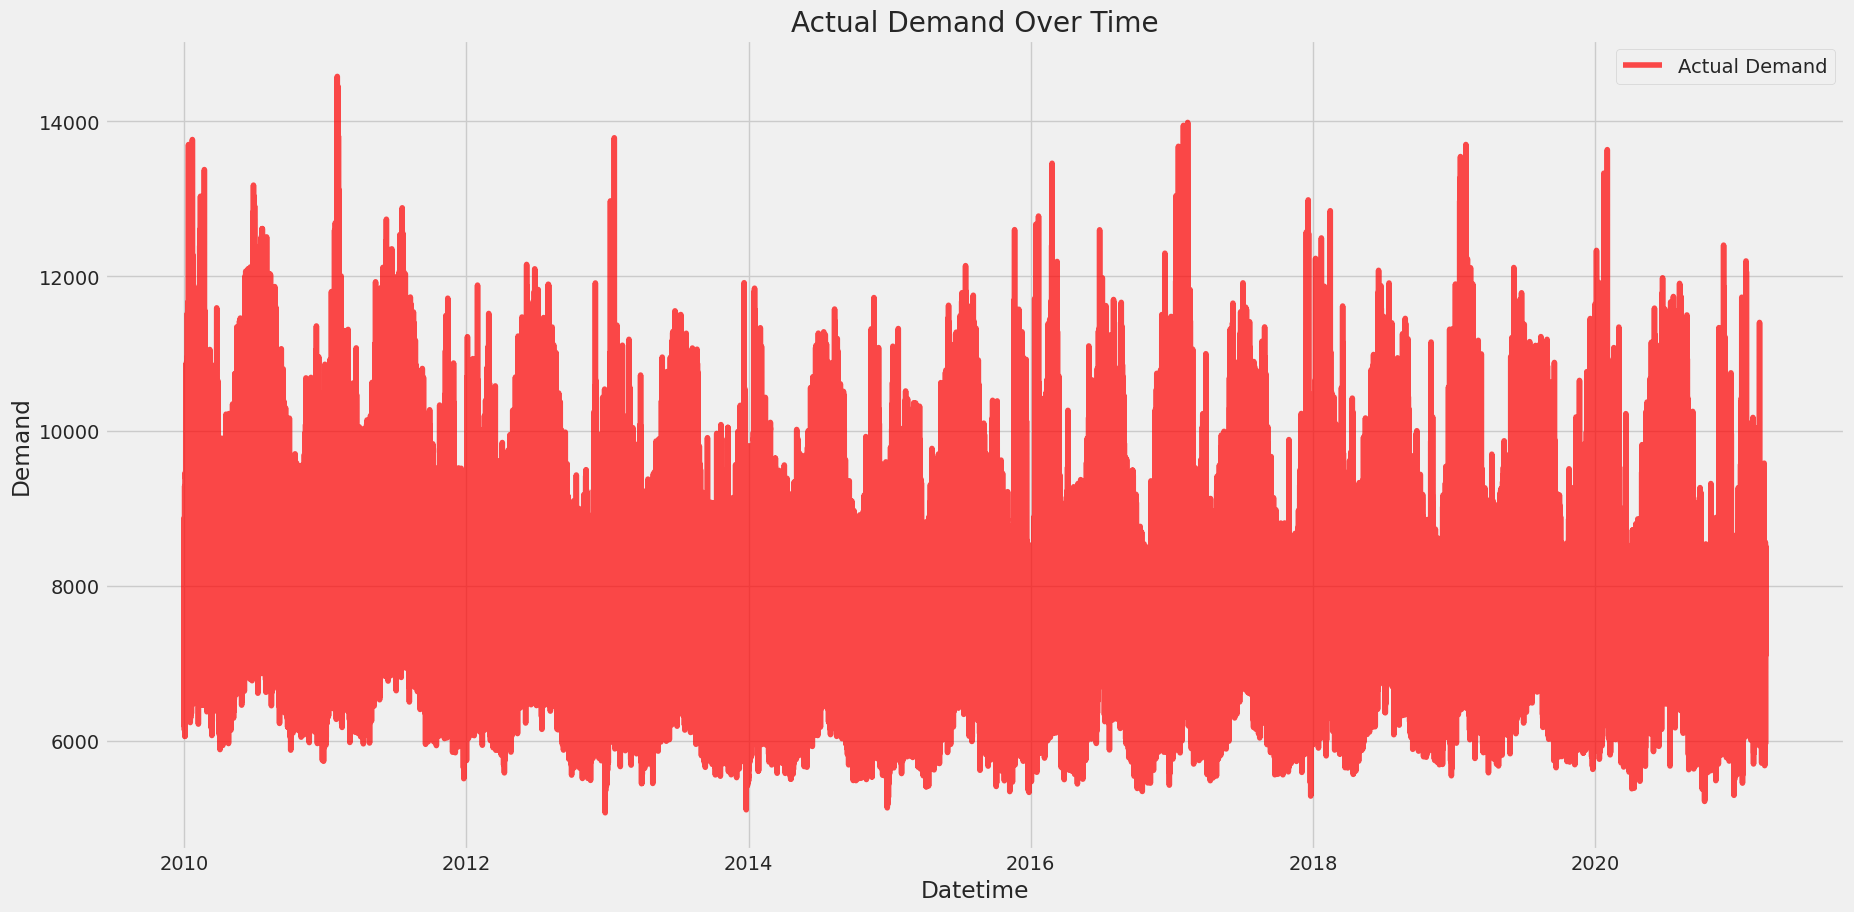

In [479]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TOTALDEMAND'], 
    label='Actual Demand', 
    color='red', 
    alpha=0.7
)
plt.xlabel('Datetime')
plt.ylabel('Demand')
plt.title('Actual Demand Over Time')
plt.legend()
plt.show()

# Temperature over time

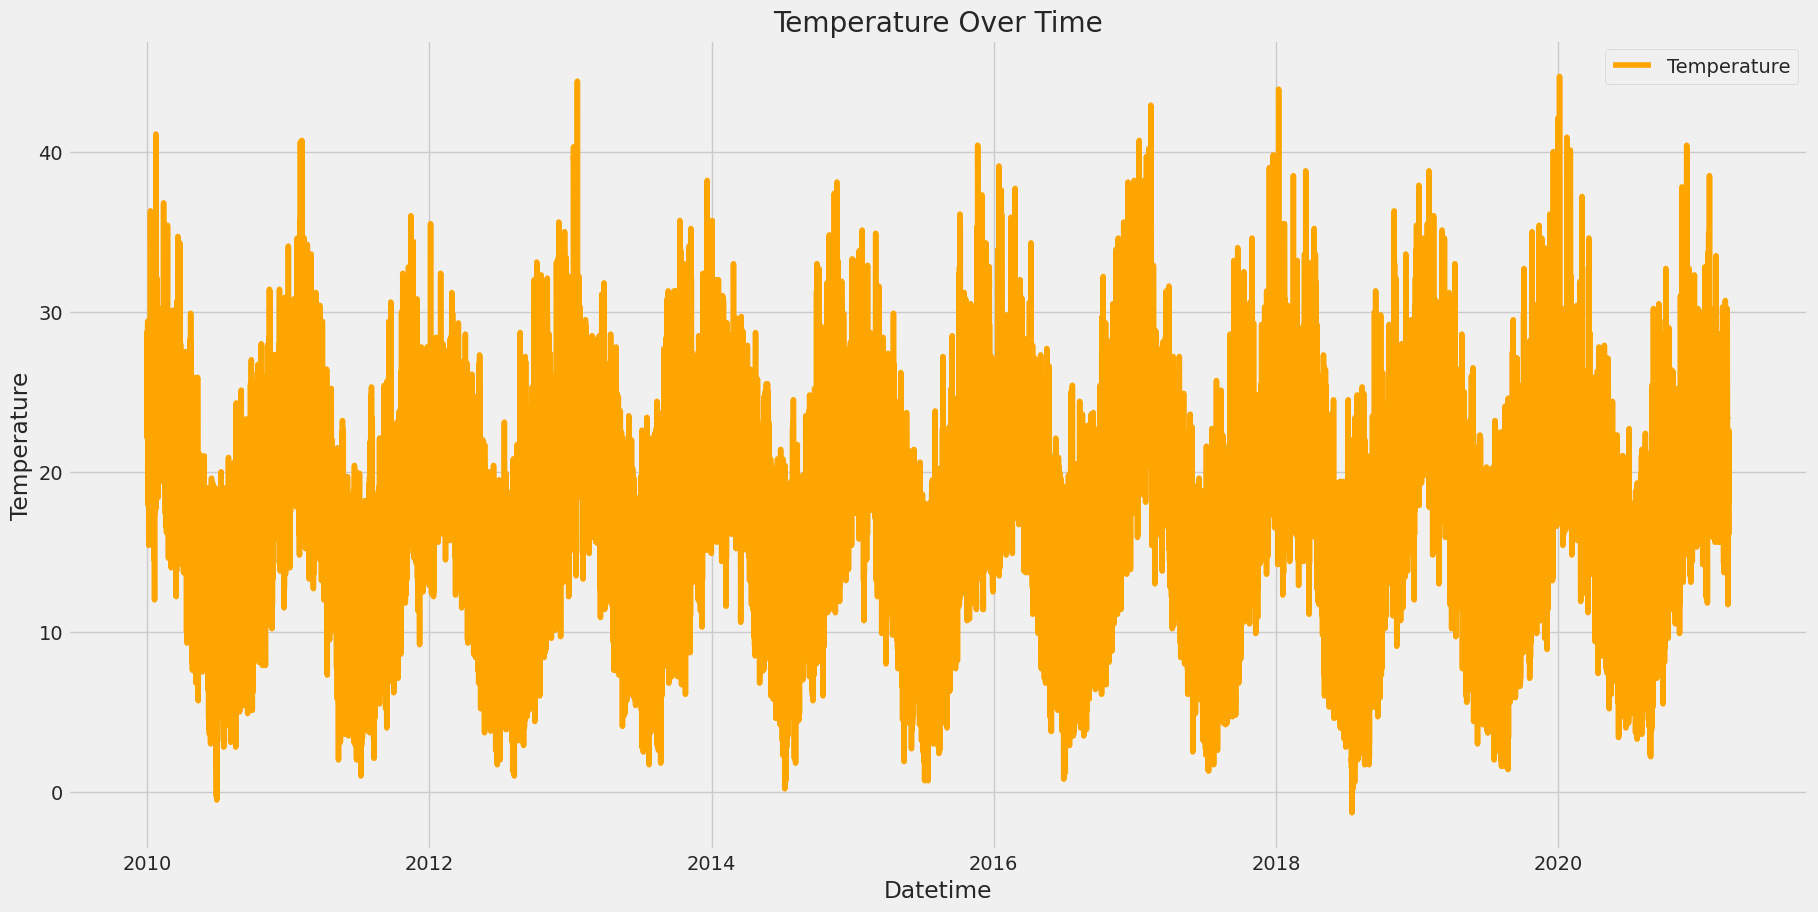

In [480]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.plot(
    nsw_df['TEMPERATURE'], 
    color='orange', 
    label='Temperature'
)
plt.xlabel('Datetime')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')
plt.legend()
plt.show()

## Scatter Plot: Temperature vs Demand
to see if higher or lower temperatures correlate with higher or lower demand

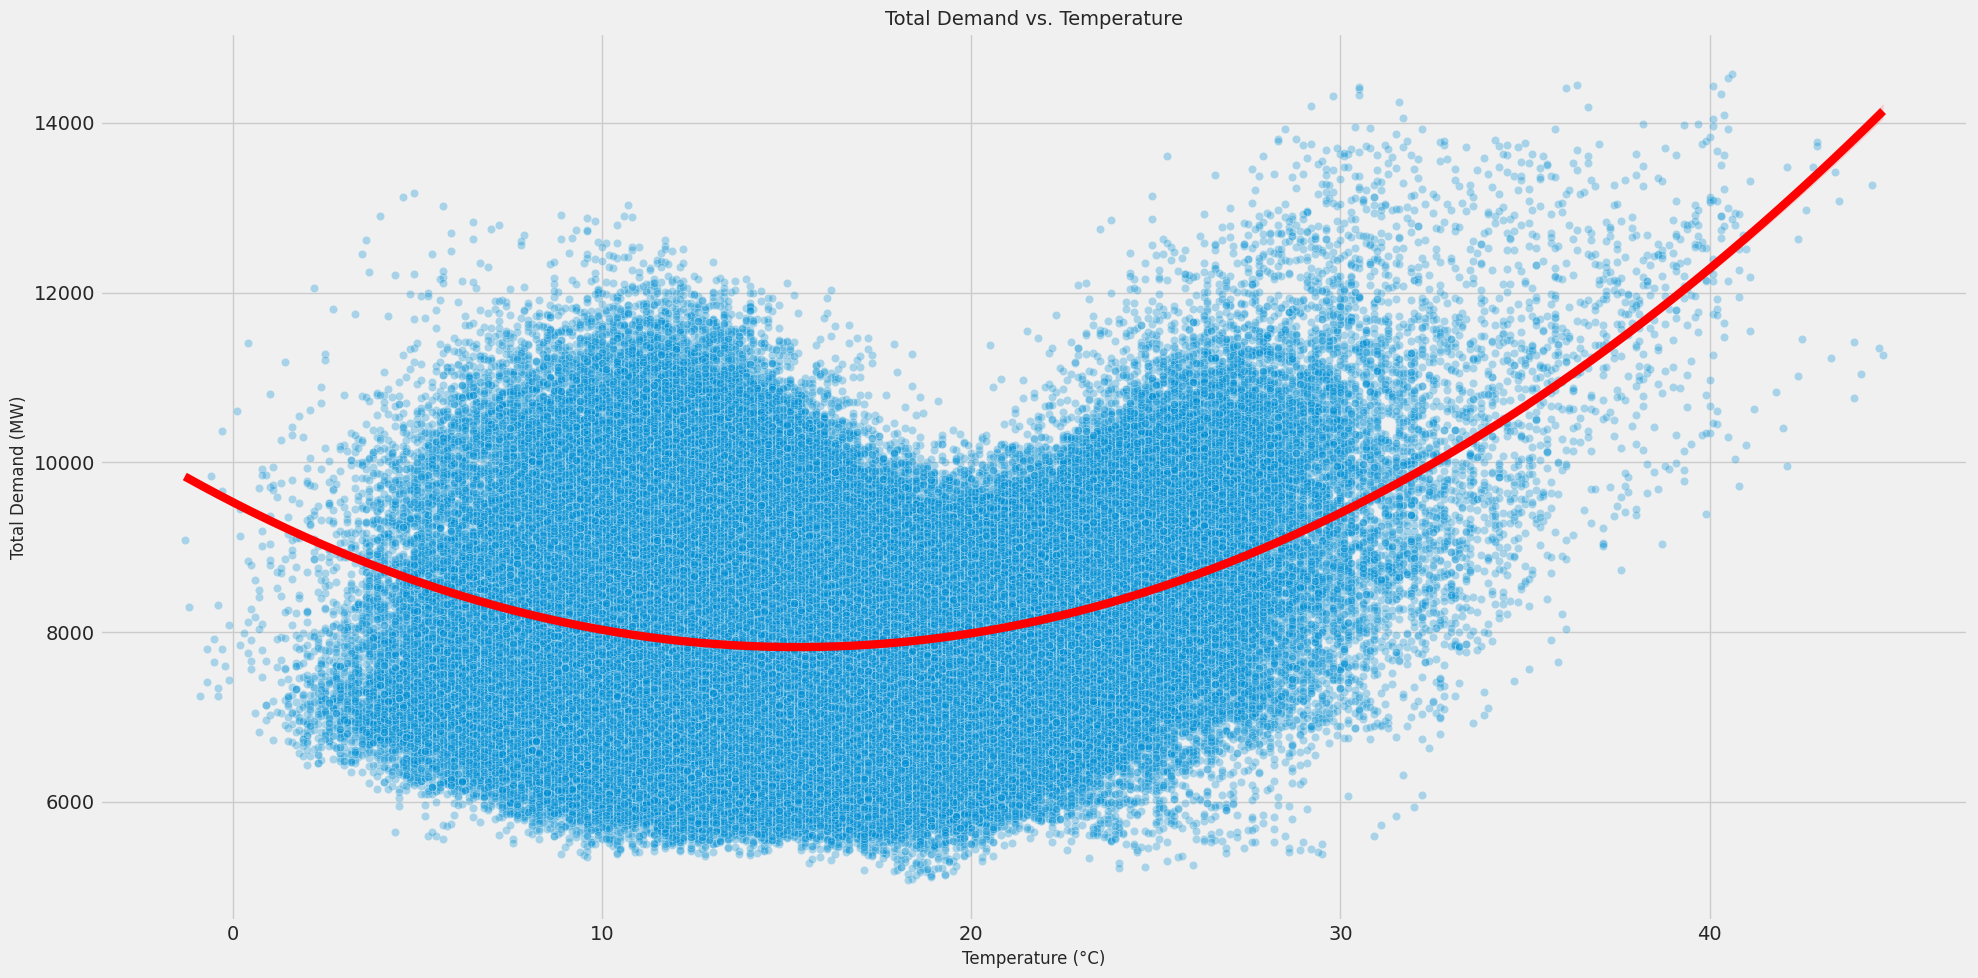

In [481]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
sns.scatterplot(x='TEMPERATURE', y='TOTALDEMAND', data=nsw_df, alpha=0.3)
# fit and plot a polynomial regression with order 2 (quadratic)
sns.regplot(x='TEMPERATURE', y='TOTALDEMAND', data=nsw_df, order=2, scatter=False, color='red')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Temperature', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

## Observations
The scatter plot shows Total Demand plotted against Temperature, with a quadratic trend line indicating the general pattern of the relationship between these two variables. Here are some observations we can infer from this plot:

1. **Non-linear Relationship**: There appears to be a non-linear, possibly quadratic relationship between temperature and total demand. Demand increases with temperature up to a certain point, after which it seems to plateau or even decline slightly.

2. **Increased Demand at Moderate Temperatures**: The highest total demand occurs at moderate temperatures, not at the extremes. This could indicate that the most energy-intensive activities (like heating and cooling) occur in a moderate temperature range.

3. **Lower Demand at Temperature Extremes**: There is a spread of demand at lower and higher temperatures, but the peaks are not as pronounced as in the moderate range. At low temperatures, this might mean adequate insulation or less need for electric heating. At high temperatures, it could imply that not all cooling is electric, or there may be a cap on how much cooling can be achieved.

4. **Possible Threshold Effect**: The trend line suggests that after a certain temperature threshold, increases in temperature do not result in significant increases in demand. This could be due to behavioral changes, energy-efficiency measures, or the saturation of cooling systems.

5. **Data Spread**: The considerable spread of data points at all temperature levels suggests that factors other than temperature also significantly influence total demand.

6. **High Variability**: There's significant variability in demand at specific temperatures, indicated by the vertical spread of points. This could be due to time-of-day effects, different days of the week, or other variables not accounted for in this two-dimensional plot.

# Scatter plot: Total demand vs time of day (temp as color)
To visualize demand patterns at different times of the day.

In [482]:
nsw_df['MinutesPastMidnight'] = nsw_df.index.hour * 60 + nsw_df.index.minute

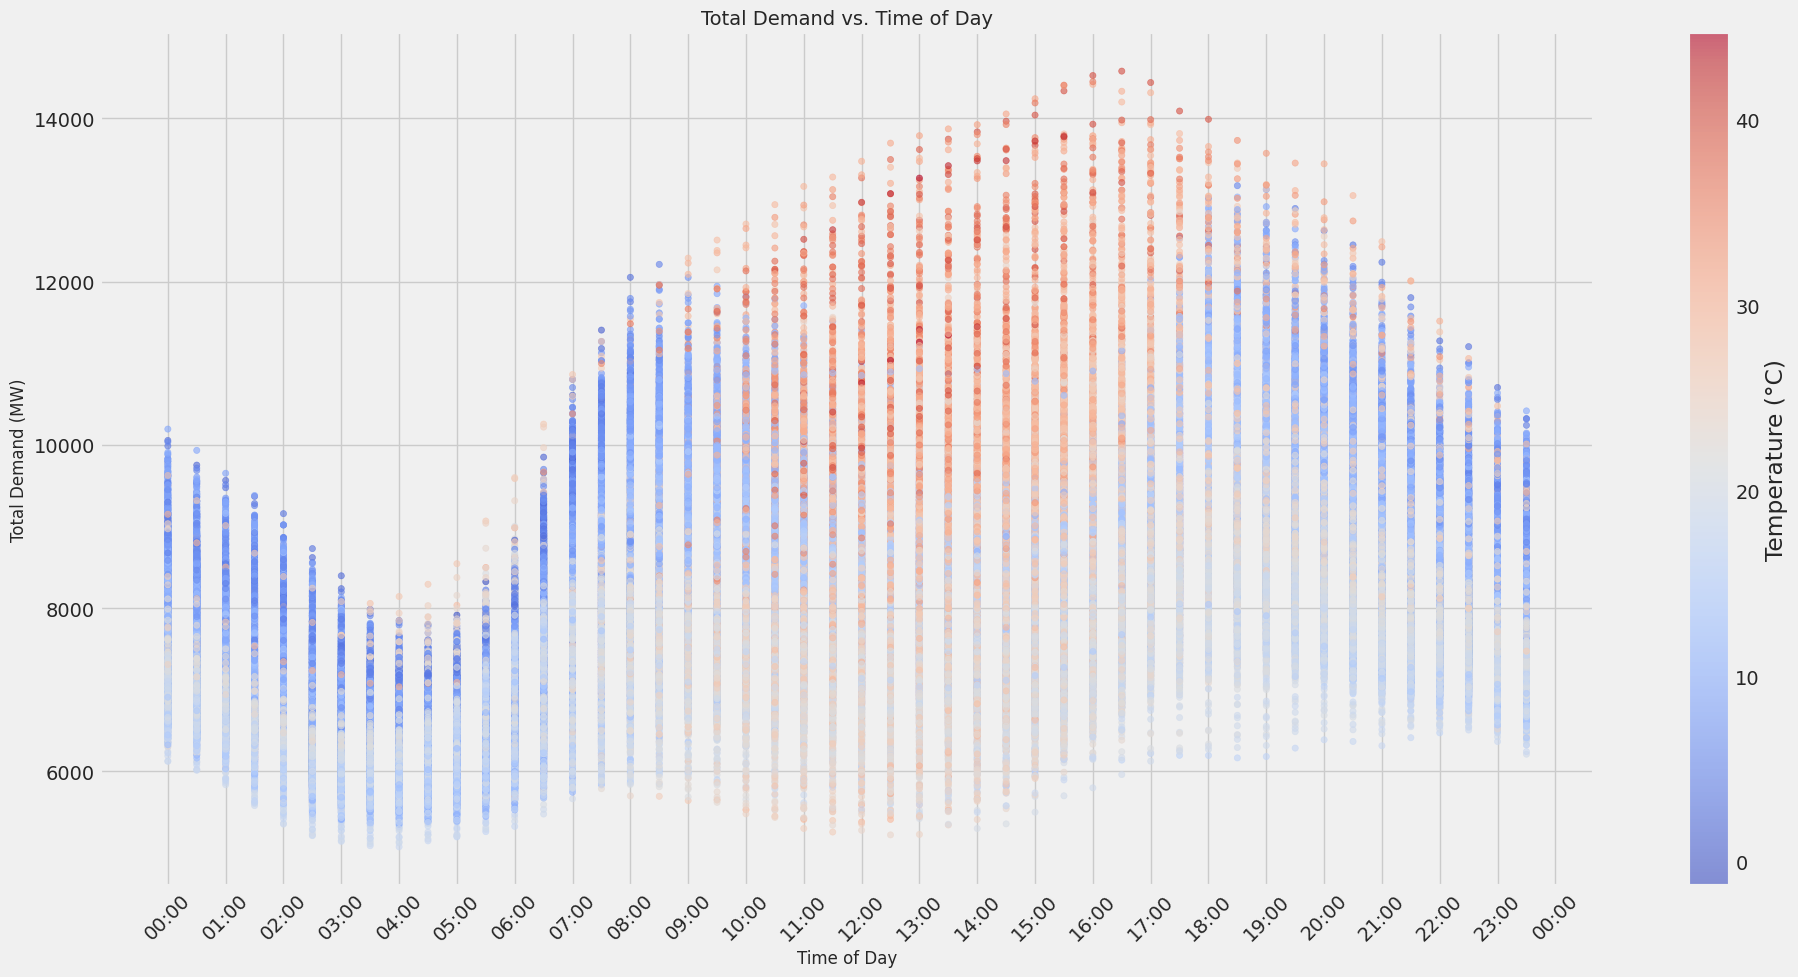

In [483]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

plt.scatter(
    nsw_df['MinutesPastMidnight'], 
    nsw_df['TOTALDEMAND'], 
    c=nsw_df['TEMPERATURE'], 
    alpha=0.6, 
    cmap='coolwarm', 
    s=20
)  

plt.colorbar(label='Temperature (°C)')
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Total Demand (MW)', fontsize=12)
plt.title('Total Demand vs. Time of Day', fontsize=14)
plt.grid(True)
tick_positions = range(0, 1441, 60)
tick_labels = [f'{h:02d}:00' for h in range(24)] + ['00:00']
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)
plt.tight_layout()
plt.show()

## Observations
1. **Demand Peaks**: It appears that there are two distinct peaks in electricity demand, likely corresponding to morning and evening hours. This is a common pattern in electricity usage, often related to increased activity as people prepare for work and school, and then again as they come home and use more appliances.

2. **Temperature Influence**: The color gradient indicates a relationship between temperature and total demand. Warmer colors at higher demand levels could suggest higher energy usage during warmer temperatures, which might be due to air conditioning and cooling systems.

3. **Cooler Temperatures**: At cooler temperatures (blue points), demand seems less intense compared to warmer temperatures, which might indicate less energy usage for heating compared to cooling, or it could suggest that the data is from a region where cooling needs are greater than heating needs.

4. **Demand Troughs**: There are clear periods where demand is lower, likely during the night when most activities cease, and there's little need for lighting and appliances.

5. **Midday Patterns**: There's a visible increase in demand around midday, which could be due to usage in commercial buildings or by industrial processes.

6. **Temperature Variability**: There's a spread of temperature values across all times, but particularly so during the times of peak demand. This suggests that on days with higher temperatures, the peaks in demand might be more pronounced.

7. **Intraday Variability**: There's significant variability in demand at any given time, which could be influenced by various factors including but not limited to temperature, such as the day of the week, holidays, or specific events.

# Scatter plot: Temperature vs Total Demand vs Forecast Demand

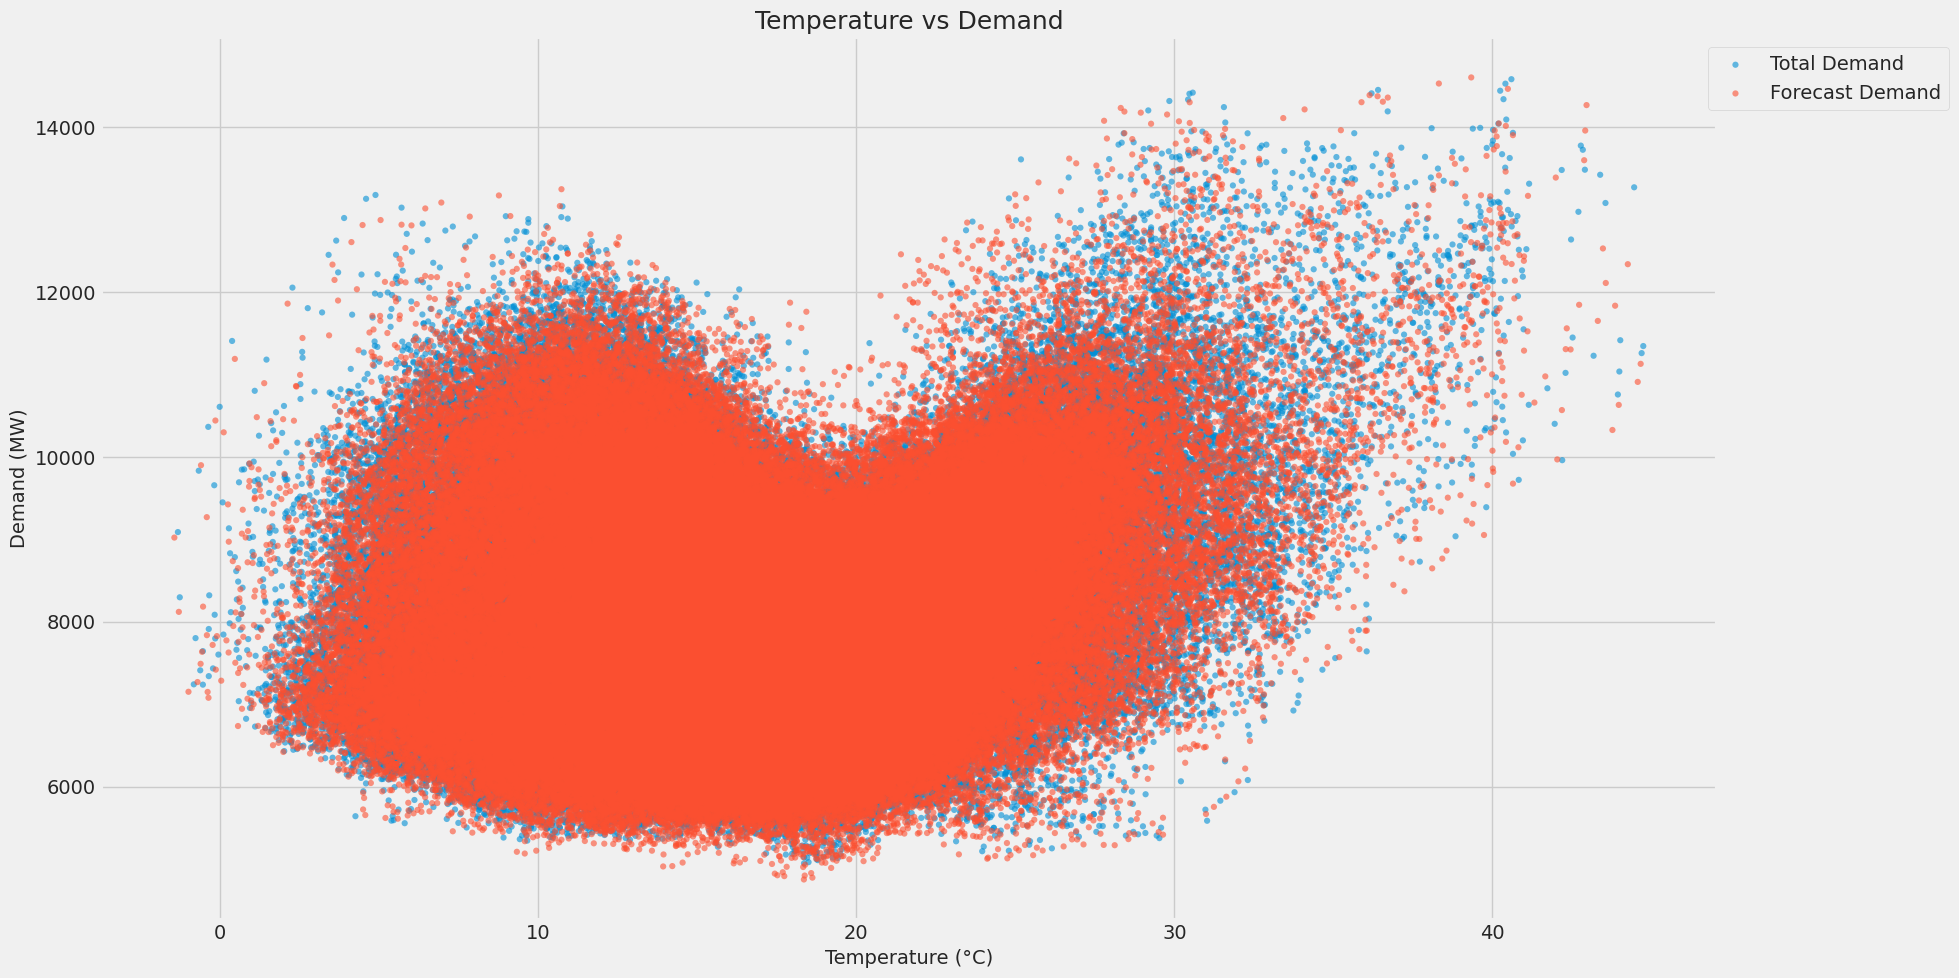

In [484]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))

sns.scatterplot(
    x=nsw_df['TEMPERATURE'] + np.random.uniform(-0.15, 0.15, size=len(nsw_df)), 
    y=nsw_df['TOTALDEMAND'], 
    label='Total Demand', 
    alpha=0.6,
    s=20,
    edgecolor='none'
)

sns.scatterplot(
    x=nsw_df['TEMPERATURE'] + np.random.uniform(-0.15, 0.15, size=len(nsw_df)), 
    y=nsw_df['FORECASTDEMAND'], 
    label='Forecast Demand', 
    alpha=0.6,
    s=20,
    edgecolor='none'
)

plt.xlabel('Temperature (°C)', fontsize=14)
plt.ylabel('Demand (MW)', fontsize=14)
plt.title('Temperature vs Demand', fontsize=18)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))  # Position the legend outside the plot

plt.grid(True)
plt.tight_layout()
plt.show()

## Observations
The plot illustrates Total Demand and Forecast Demand as they relate to Temperature, depicted in different colours for comparison. Here’s what we can interpret from this plot:

1. **Forecast vs. Actual Demand**: Both total and forecast demand show a similar trend with temperature, suggesting the forecasting model is generally capturing the temperature-related variability in demand. However, the non-overlapping areas highlight where the forecast demand significantly deviates from the actual demand. This could occur during unexpected temperature fluctuations or when other factors influencing demand are not accounted for in the forecasting model.

2. **Spread of Forecast**: The forecast demand data points are spread across a wide range of the actual demand values, especially at mid-range temperatures. This could indicate potential inaccuracies in the forecast during those conditions, or it might reflect natural variability in demand that isn't fully captured by temperature alone.

3. **Higher Temperatures**: At higher temperatures, both total and forecast demand are elevated, which typically corresponds with increased use of cooling systems. The forecasts appear to follow this trend. However, it also looks like the model may be less accurate under extreme temperature conditions where the behavior of the demand might be less predictable or more volatile.

4. **Lower Temperatures**: Similarly, increased demand at lower temperatures is likely due to heating needs. The forecast demand also follows this trend. similar comment to high temps

5. **Concentration of Data**: There seems to be a dense concentration of data points at certain temperatures, indicating common temperature ranges for the dataset. Less dense areas also represent areas that are less accurate.

6. **Discrepancies**: There are noticeable discrepancies between forecast and actual demand at certain temperatures. Why

7. **Model Performance**: The overlay of forecast on actual demand can be used to evaluate the performance of the forecasting model across the temperature range. The closer the fit, the better the model is at capturing the impact of temperature on demand.

8. **Temperature Extremes**: Both demand values tend to be higher at the temperature extremes, suggesting a U-shaped relationship where both heating and cooling drive up energy demand.

This visual comparison is valuable for understanding how well the forecasting model performs relative to actual demand. 

## Histogram: total demand distribution
to get an idea of the most common demand levels

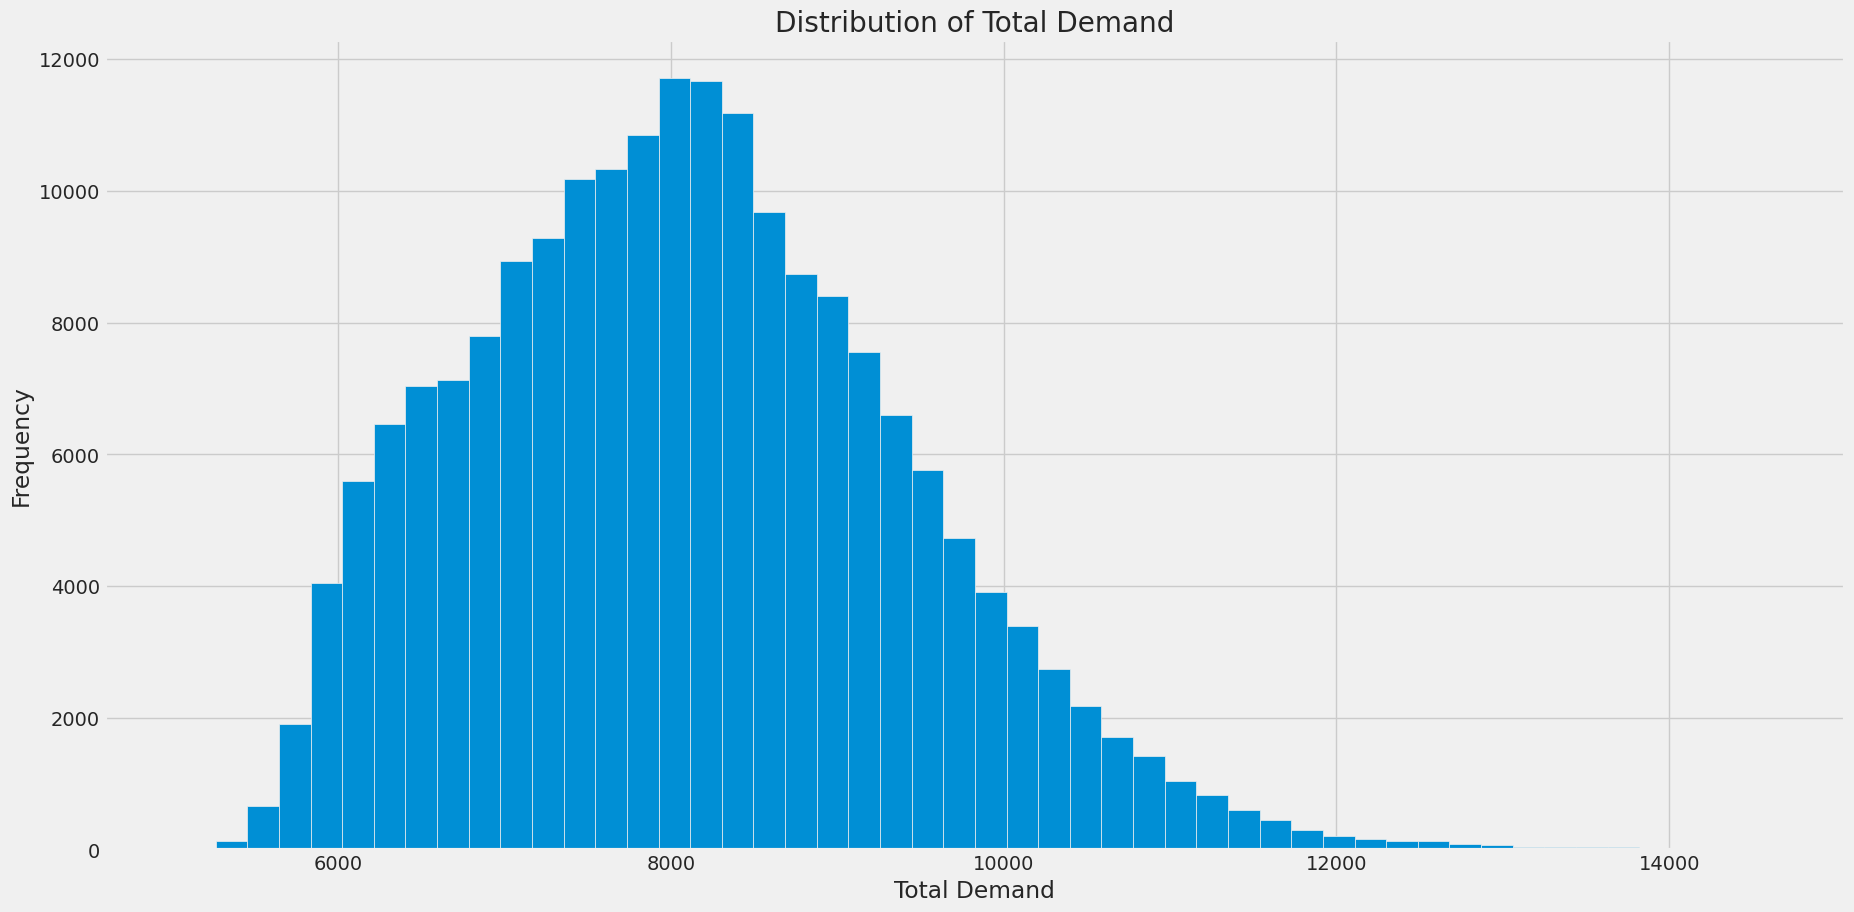

In [485]:
nsw_df['TOTALDEMAND'].hist(bins=50)
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

## Histogram: temperature distribution

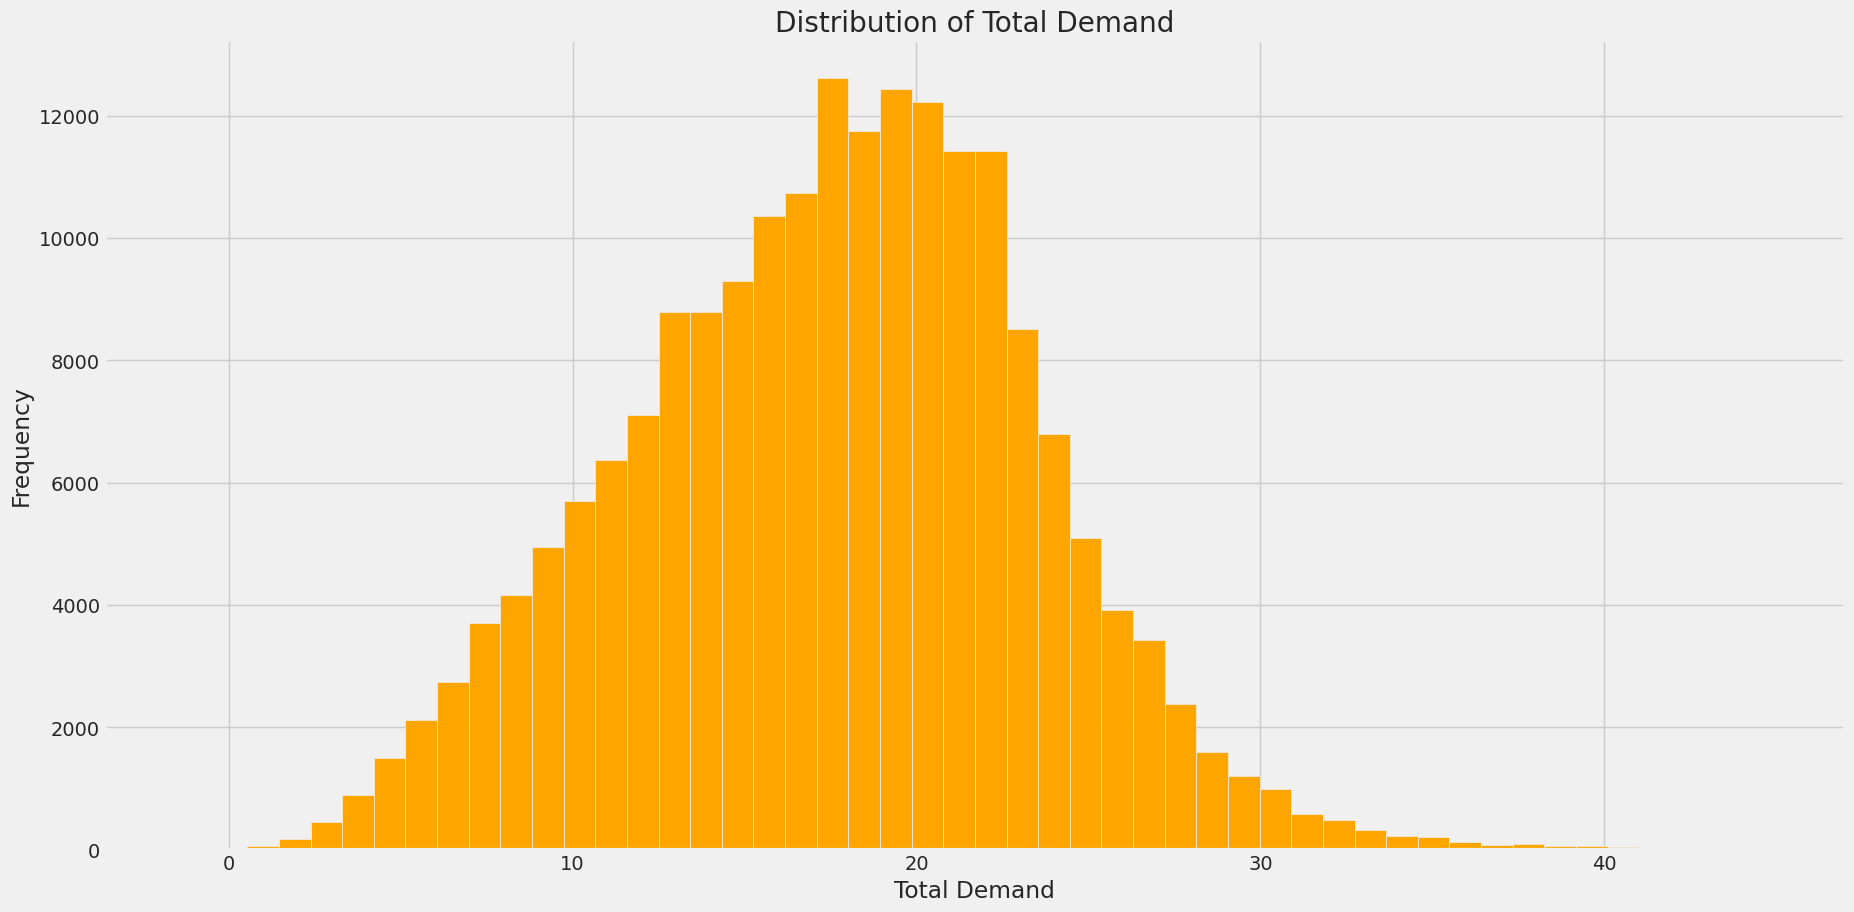

In [486]:
nsw_df['TEMPERATURE'].hist(bins=50, color='orange')
plt.xlabel('Total Demand')
plt.ylabel('Frequency')
plt.title('Distribution of Total Demand')
plt.show()

# KDE of Total demand
to see the probability density of the total demand levels

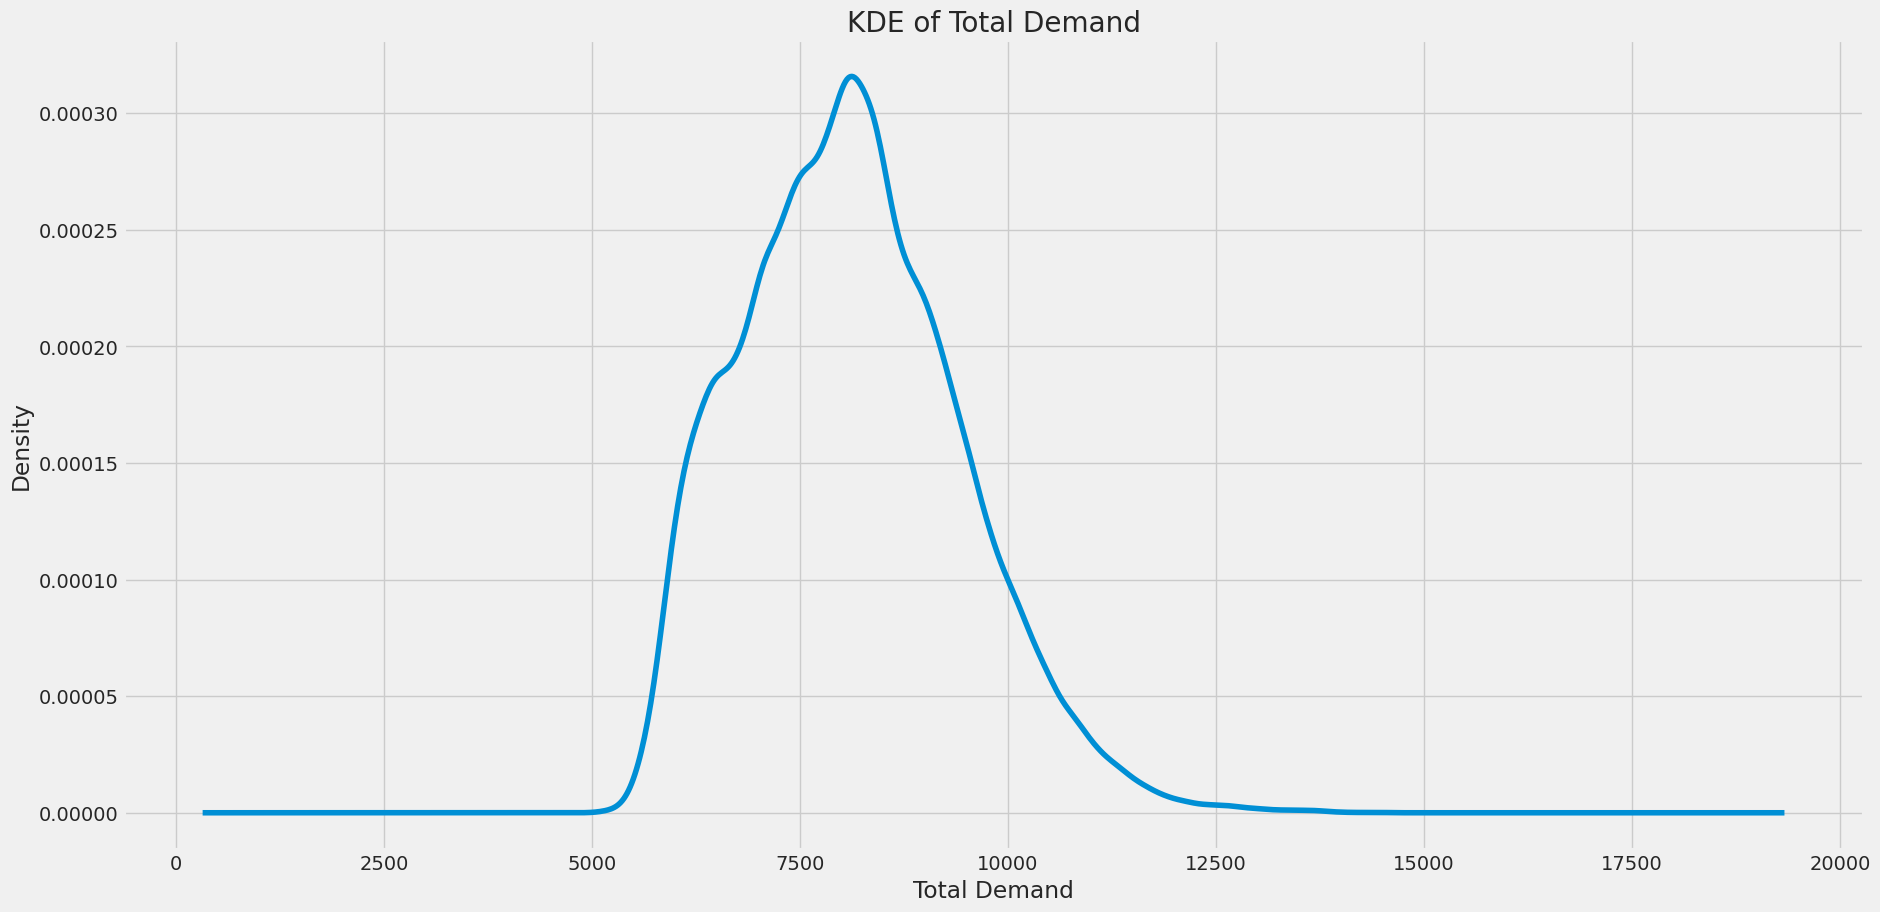

In [487]:
nsw_df['TOTALDEMAND'].plot(kind='kde')
plt.xlabel('Total Demand')
plt.title('KDE of Total Demand')
plt.show()

## Pandas autocorrelation plot

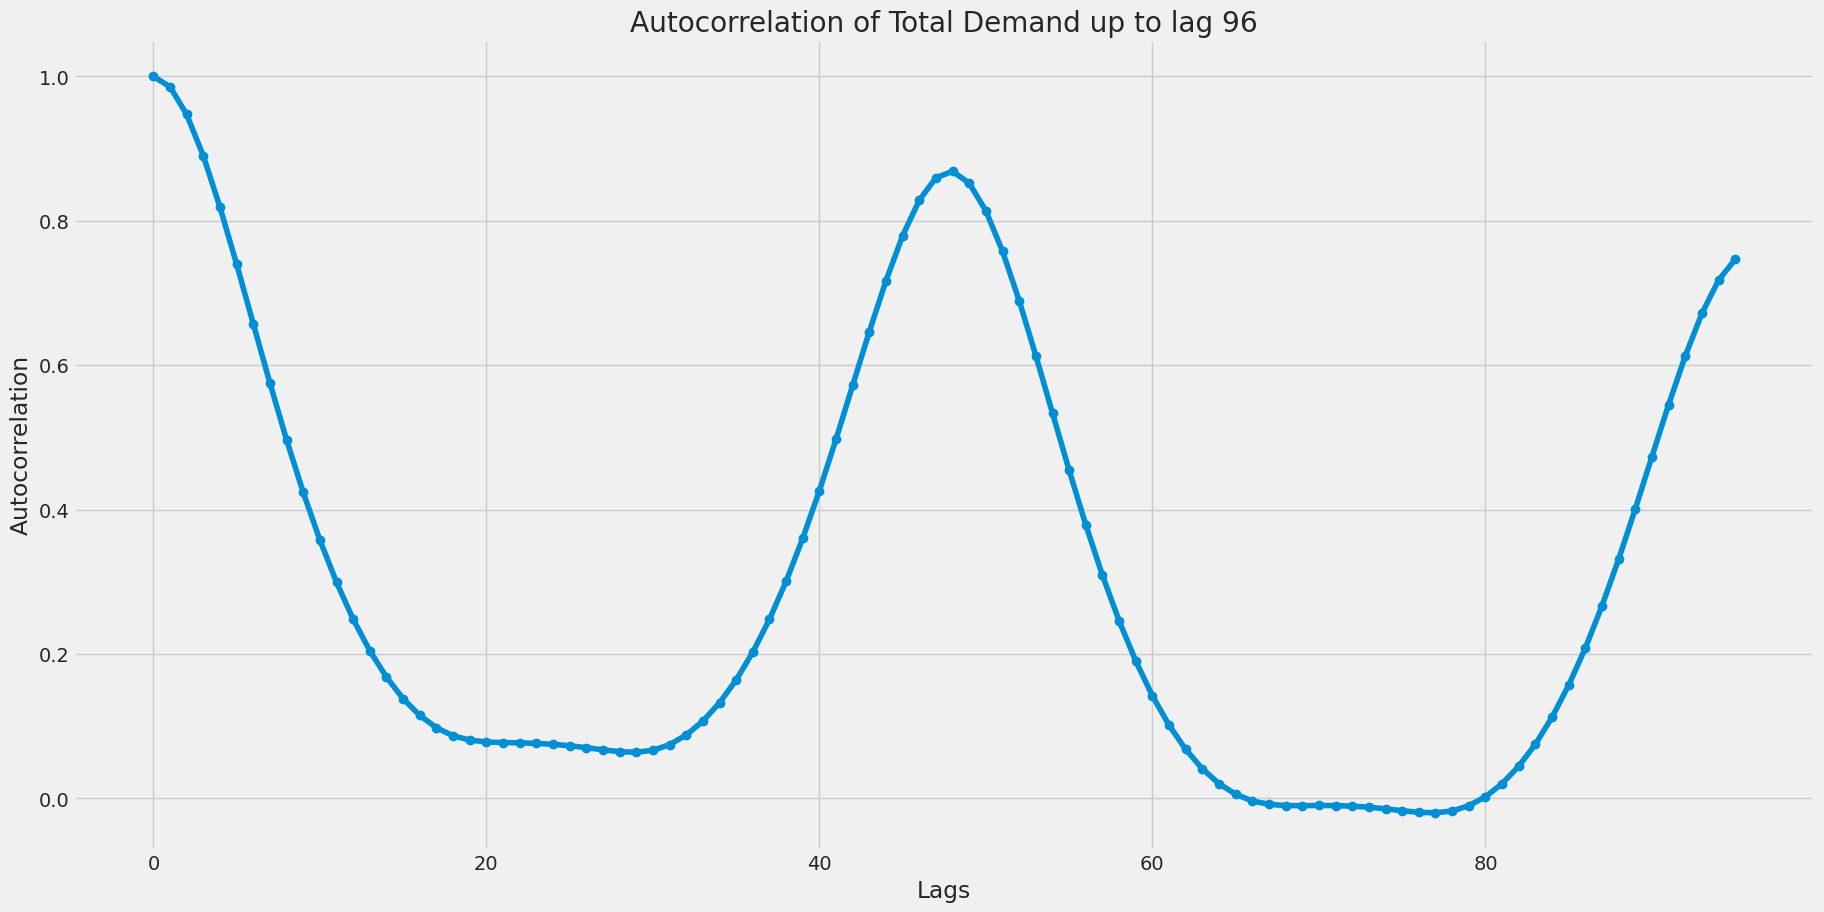

In [488]:
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
max_lags = 96
autocorrelation_values = [nsw_df['TOTALDEMAND'].autocorr(lag=i) for i in range(max_lags)]
plt.plot(autocorrelation_values, marker='o')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Total Demand up to lag {}'.format(max_lags))
plt.show()

## Observations
For half-hourly data, 96 lags represent a full two days. From the autocorrelation plot, we can make some key interpretations:

1. **High Initial Autocorrelation**: The autocorrelation starts at 1 (as it must, since this represents correlation with itself at lag 0) and remains high over the initial lags, which suggests that the demand data is strongly influenced by its immediate past values. This could be due to consistent patterns of demand across adjacent time intervals.

2. **Daily Seasonality**: The peak in autocorrelation at lag 48 (which represents a full day's lag for half-hourly data) indicates a strong daily seasonal pattern. The demand at the same time on one day is highly correlated with the demand at the same time on the next day.

3. **Two-Day Cycle**: The second peak at lag 96 shows that the demand also correlates with itself two days apart. This reinforces the daily seasonality and suggests a stable pattern of demand that repeats every 48 half-hour period.

4. **Troughs at Intermediate Lags**: The troughs at lags that are halfway between the peaks (around 24 and 72) may suggest a less significant correlation at these intermediate points. This could be due to the contrast between daytime and nighttime demand or the differences in demand patterns between workdays and non-workdays.

This autocorrelation structure indicates that any models for forecasting or analysis should account for daily seasonality. Time series models such as ARIMA with seasonal components or machine learning models with lagged features might be well-suited to capture and predict these patterns.

# Boxplot
I'm now using z-score normalisation instead of log transform because temperature contains zero and negative values

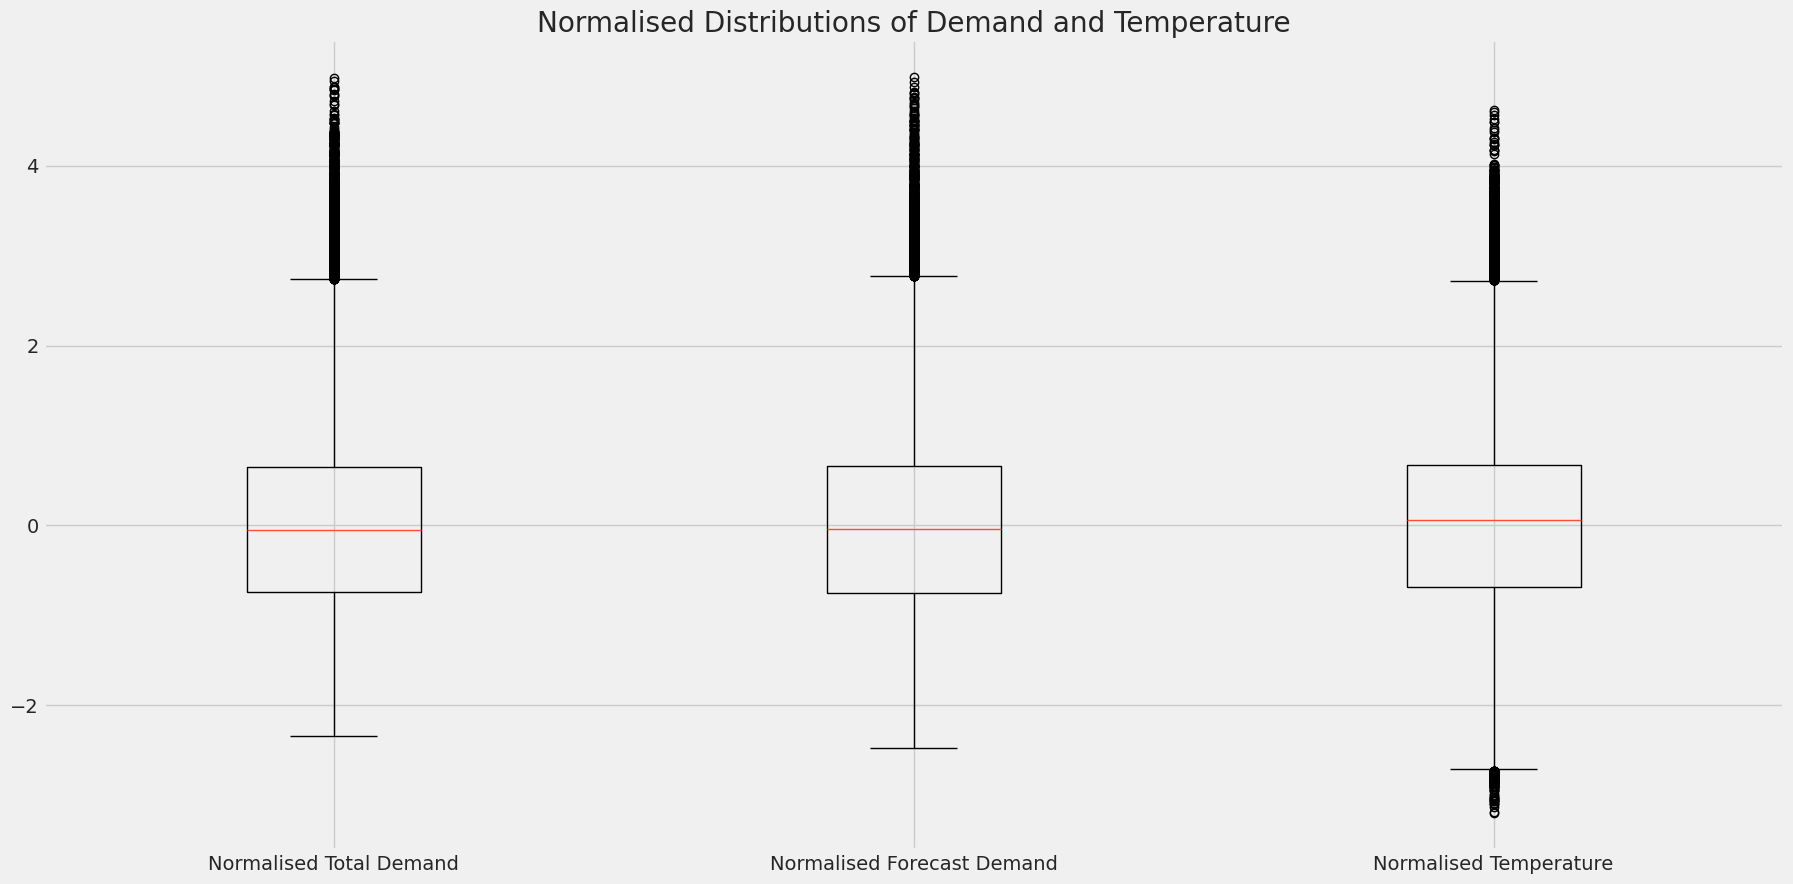

In [489]:
# Apply z-score normalization
nsw_df['NormalisedTotalDemand'] = zscore(nsw_df['TOTALDEMAND'])
nsw_df['NormalisedForecastDemand'] = zscore(nsw_df['FORECASTDEMAND'])
nsw_df['NormalisedTemperature'] = zscore(nsw_df['TEMPERATURE'])

# Plot the box plots for the normalized values
plt.figure(figsize=(CFG.img_dim1, CFG.img_dim2))
plt.boxplot(
    [
        nsw_df['NormalisedTotalDemand'], 
        nsw_df['NormalisedForecastDemand'],
        nsw_df['NormalisedTemperature']
    ],
    labels=['Normalised Total Demand', 'Normalised Forecast Demand', 'Normalised Temperature']
)
plt.title('Normalised Distributions of Demand and Temperature')
plt.show()

## Observations
Based on the box plot for the normalised distributions of Total Demand, Forecast Demand, and Temperature:

1. **Central Tendency**: The median of the Total Demand and Forecast Demand (indicated by the line in the middle of the box) are at or near zero, which is expected after normalization. It seems the median for Temperature is also close to zero after normalization.

2. **Variability**: The interquartile range (IQR, represented by the box) is more extended for Total Demand compared to Forecast Demand, indicating greater variability in actual demand. The IQR for Temperature appears much smaller, suggesting less variability relative to its mean.

3. **Outliers**: The presence of outliers is indicated by the points beyond the whiskers in both Total Demand and Forecast Demand. These are individual data points that lie beyond the typical range (1.5 times the IQR).

4. **Symmetry**: The distributions for both demand variables appear reasonably symmetrical around their median, though Total Demand has a notable number of high outliers.

5. **Comparison of Distributions**: The fact that both demands have similar box heights (IQRs) but Total Demand has more outliers could indicate that extreme values are more common in the actual demand than forecasted. 

6. **Temperature Distribution**: Even though the temperature is normalized, the small IQR and the presence of outliers suggest that there are times when the temperature is significantly different from the mean temperature.

# Decomposition

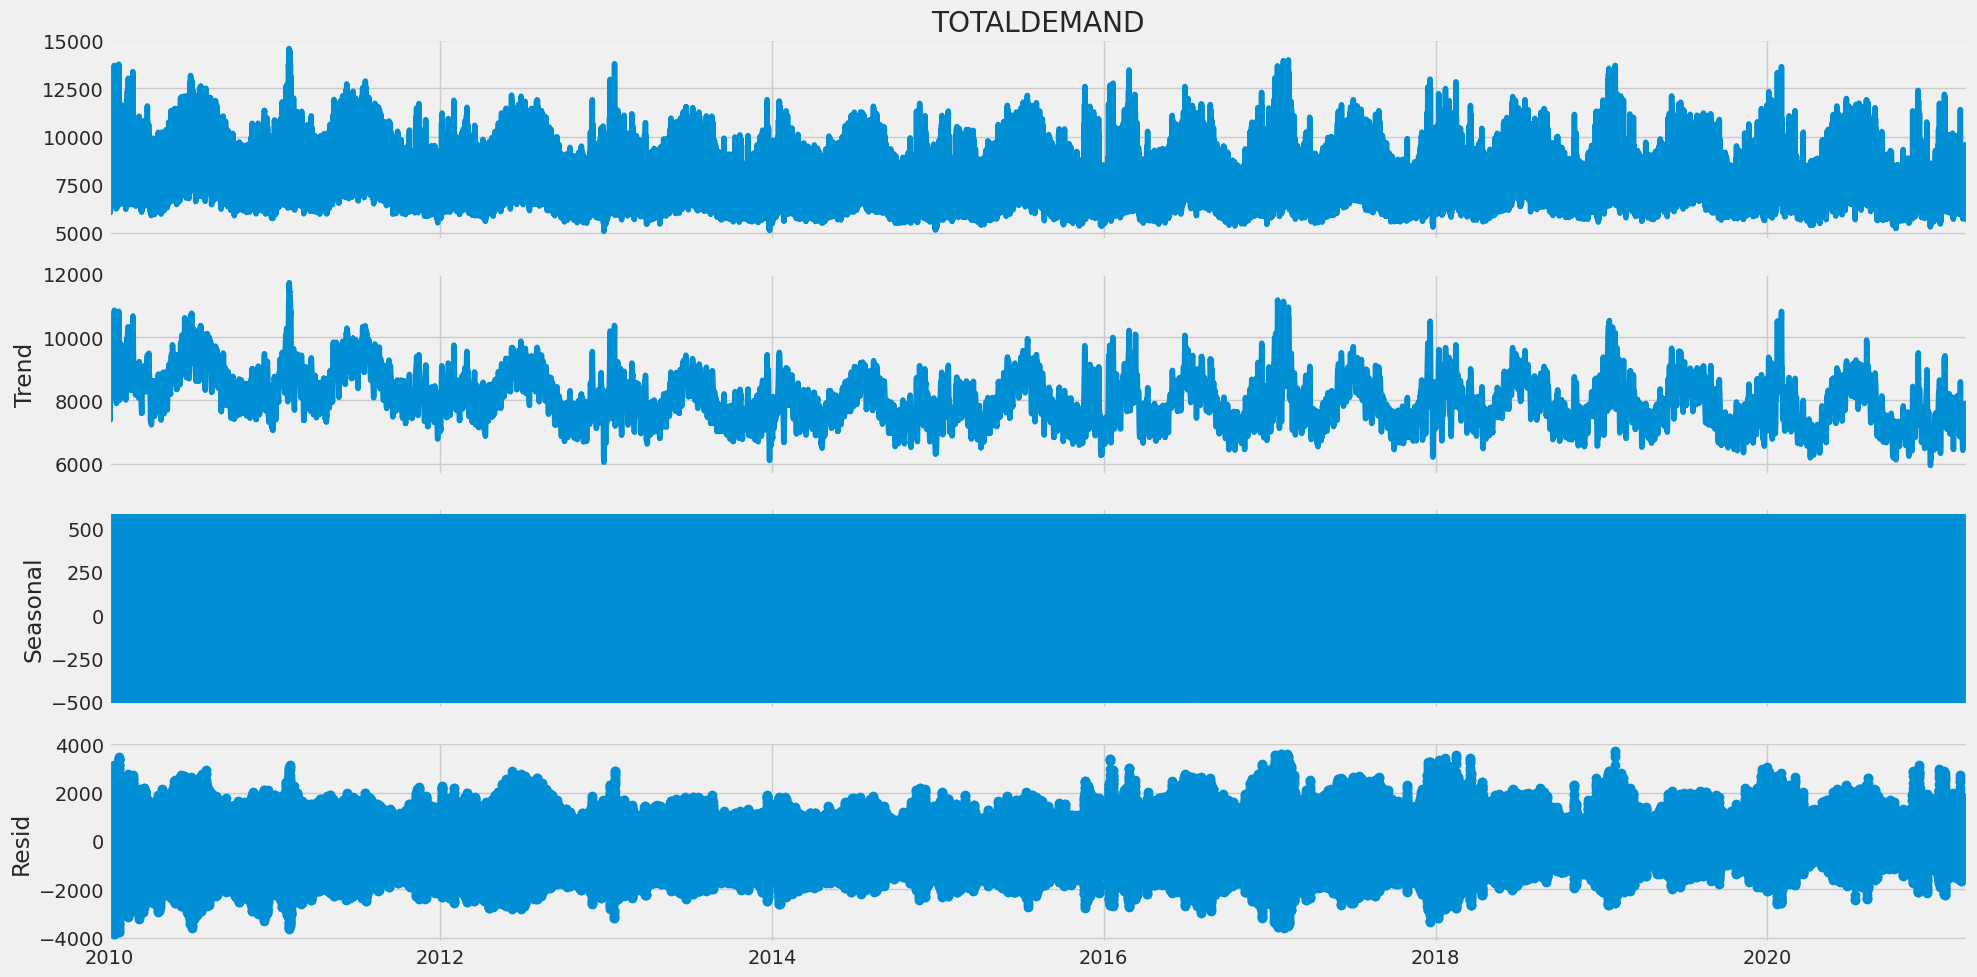

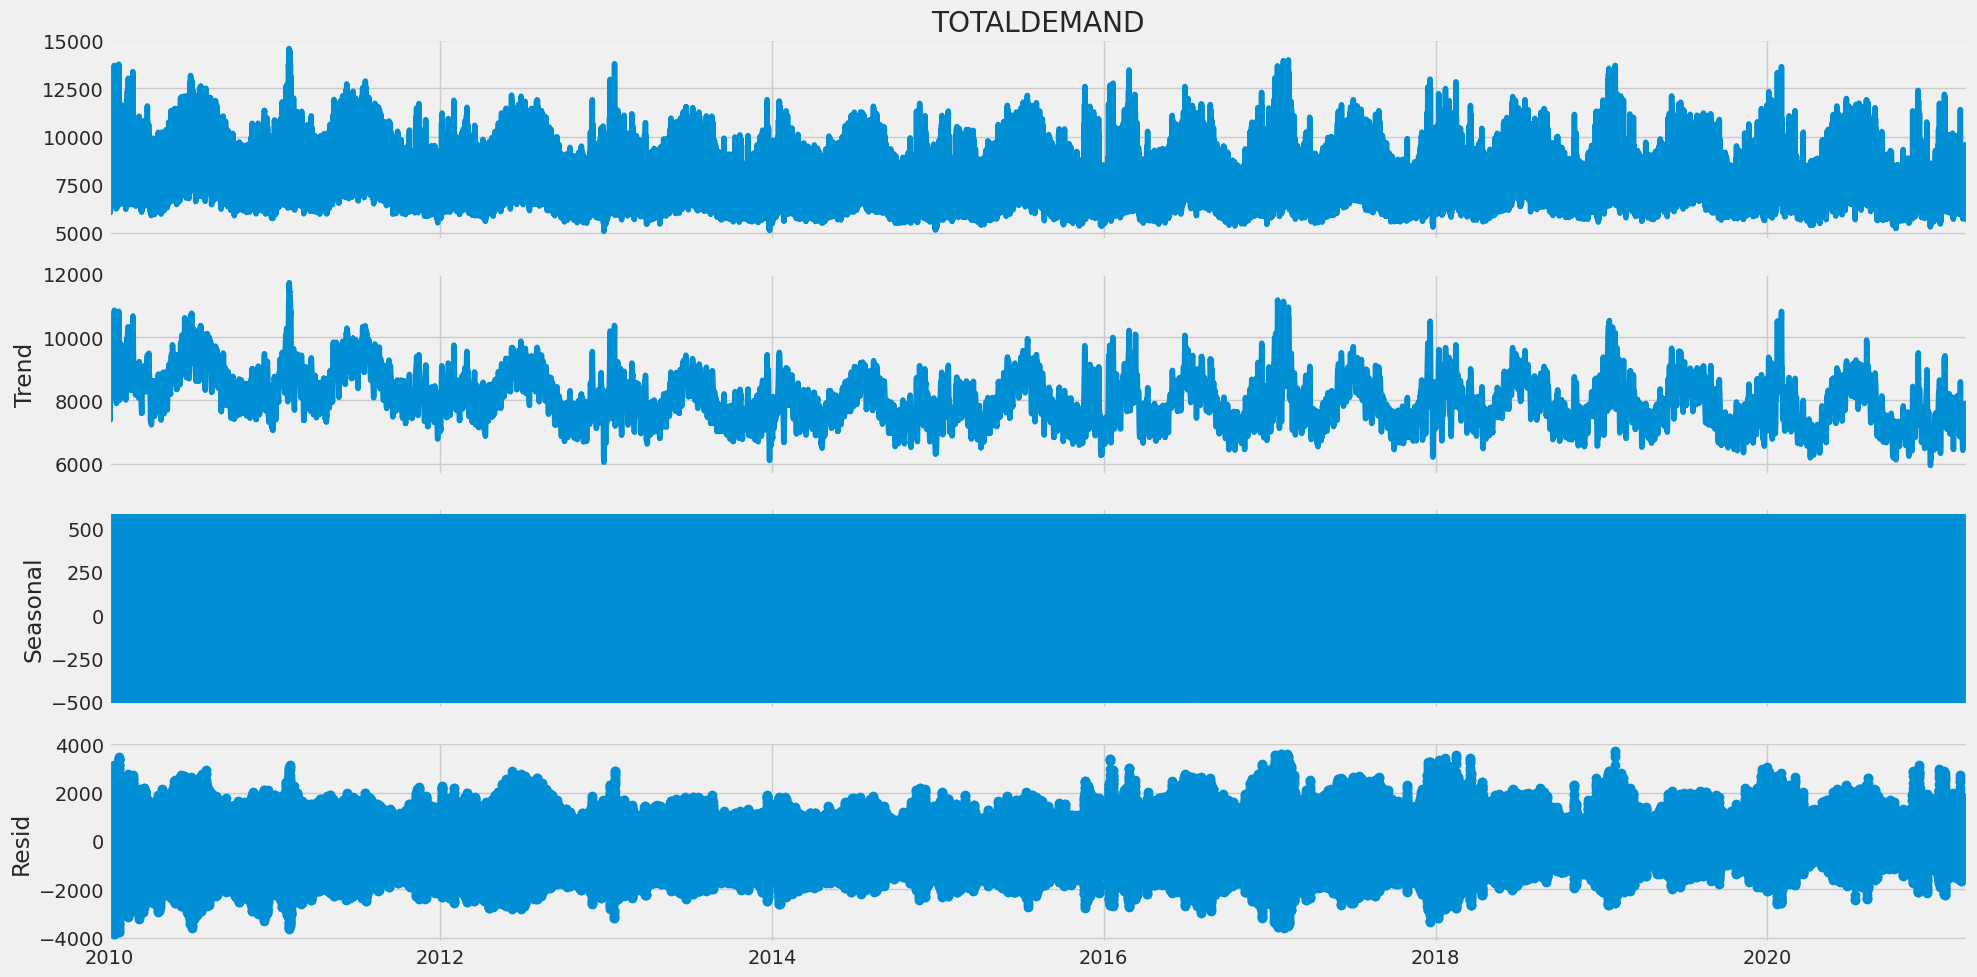

In [490]:
res = seasonal_decompose(
    nsw_df['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res.plot()

# Decomposition of 1 year of data

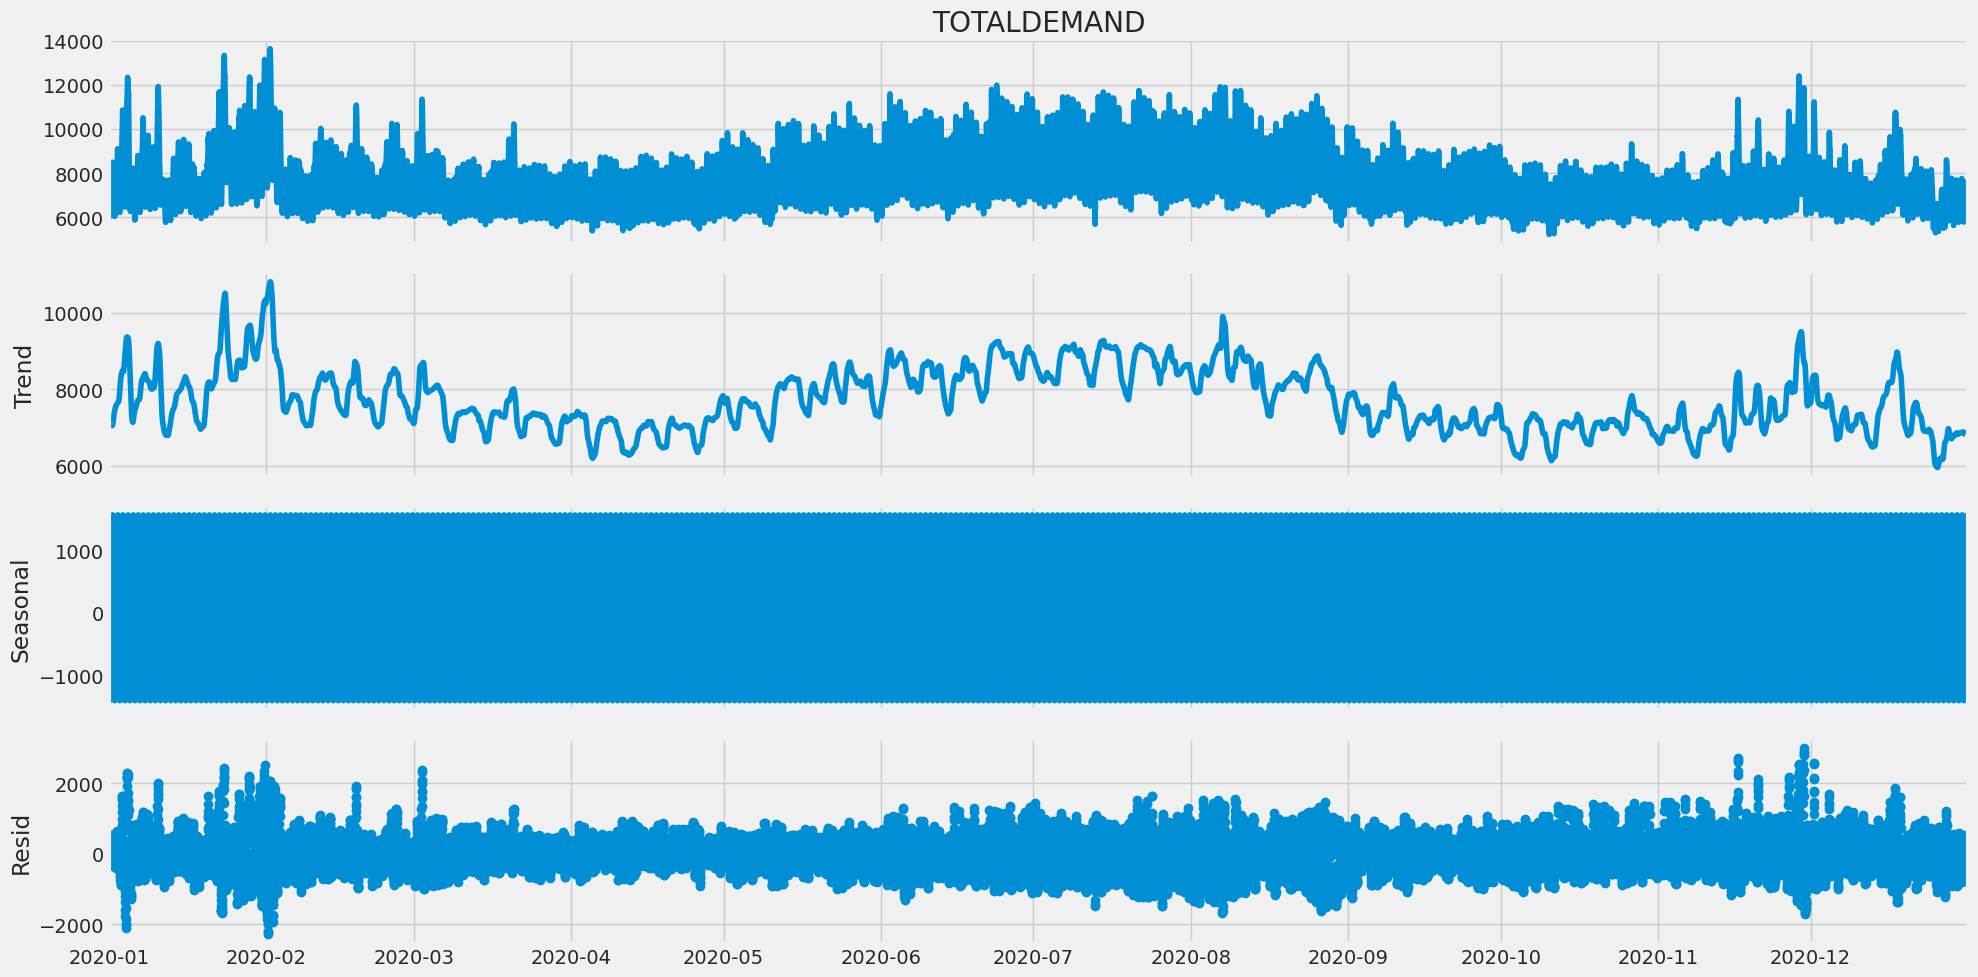

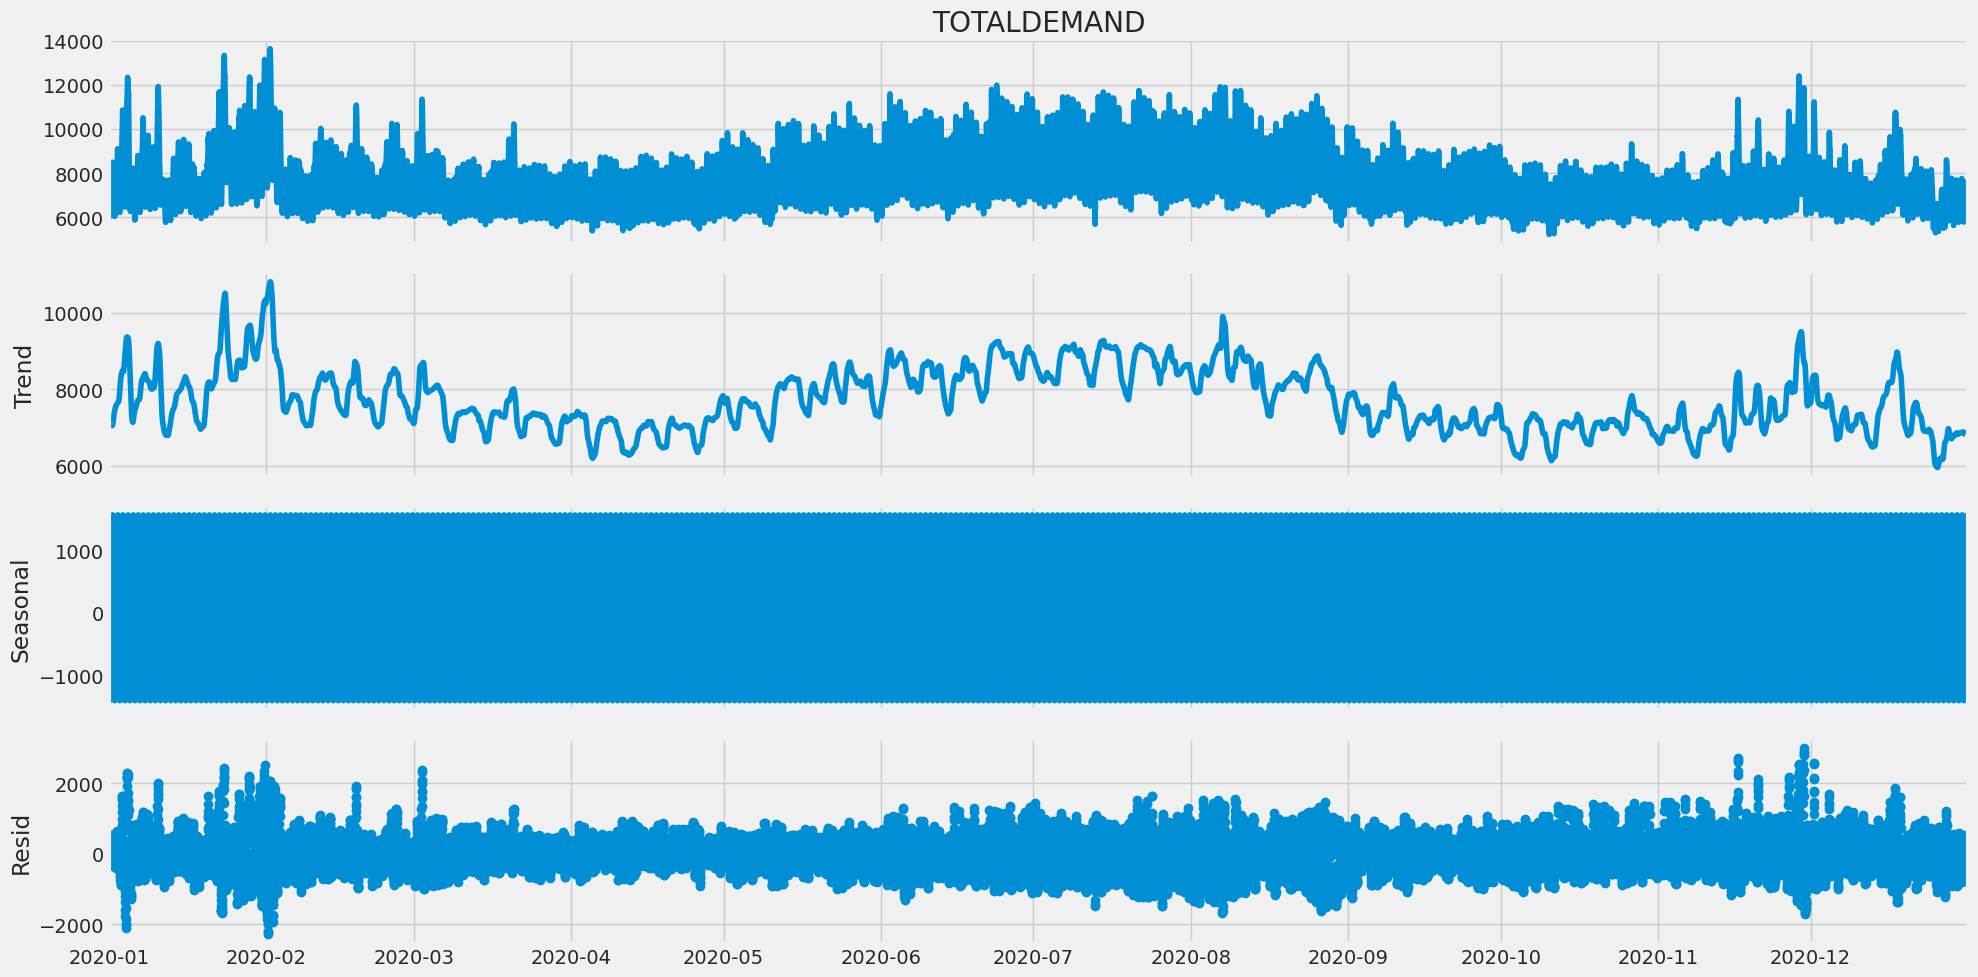

In [491]:
one_year_data = nsw_df.loc['2020']
res_one_year = seasonal_decompose(
    one_year_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_year.plot()

### decompose for one week

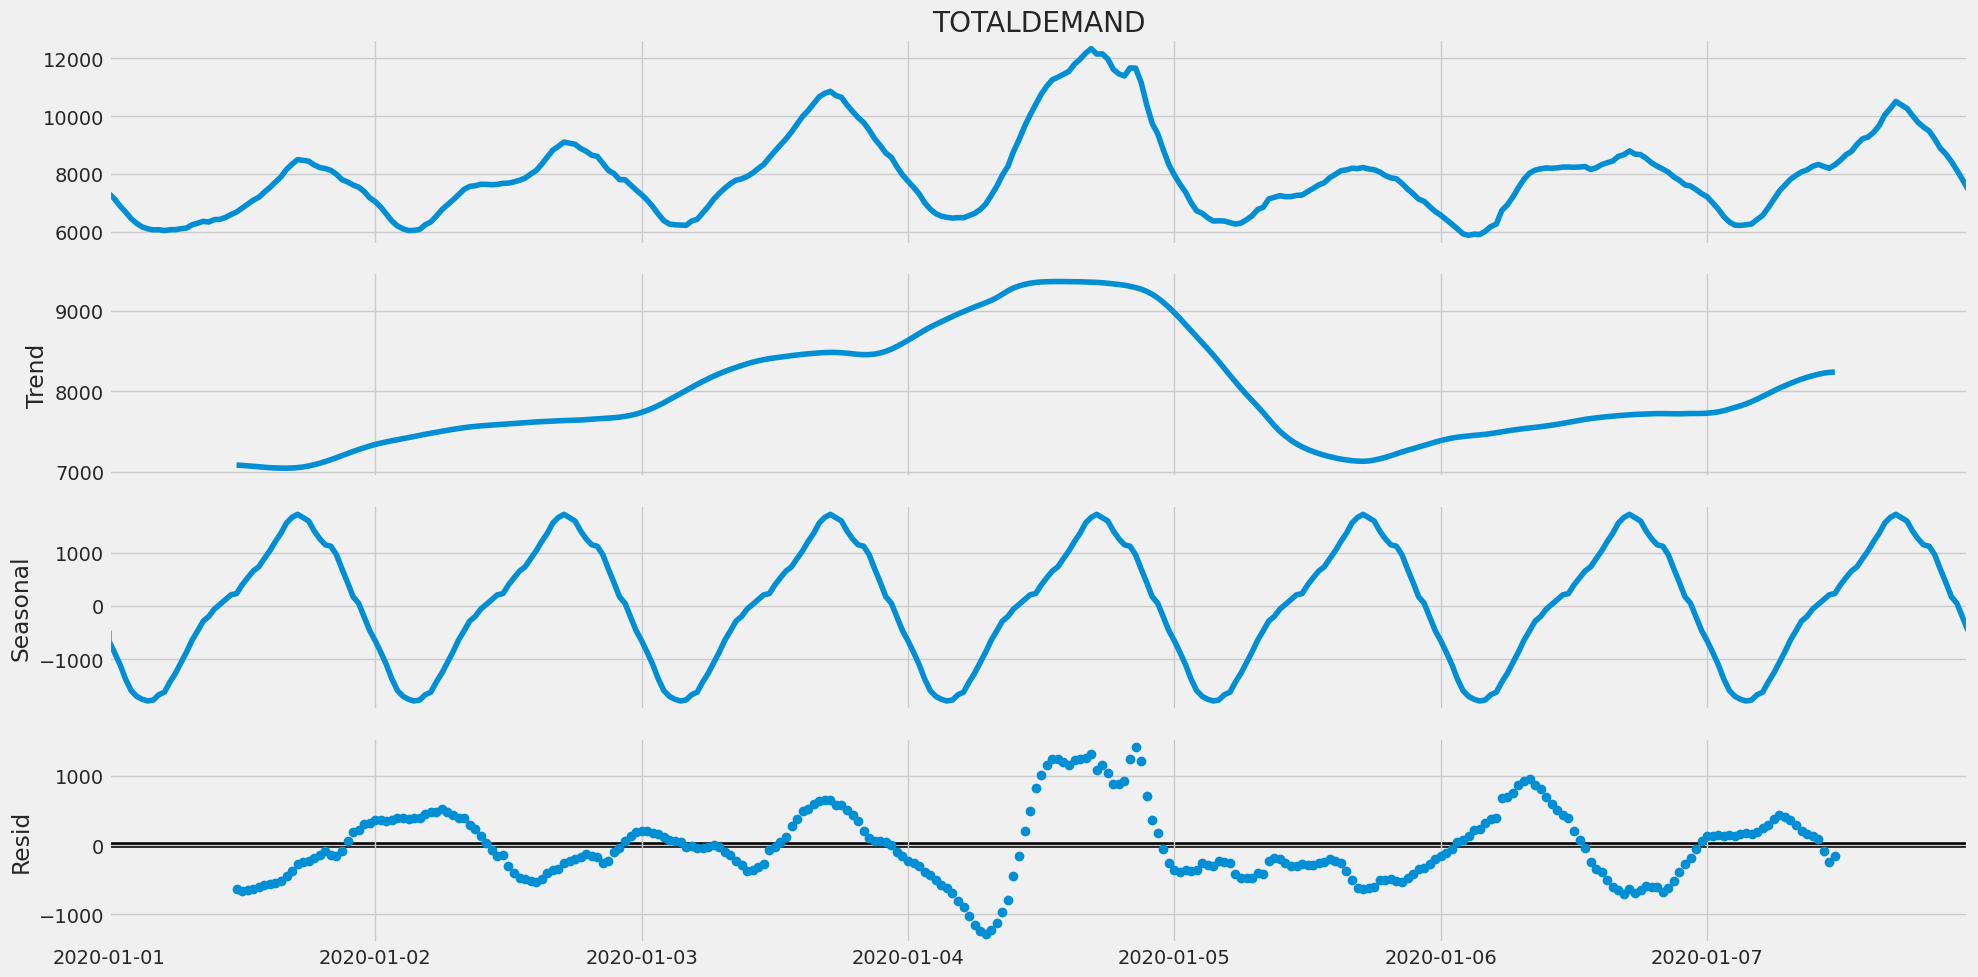

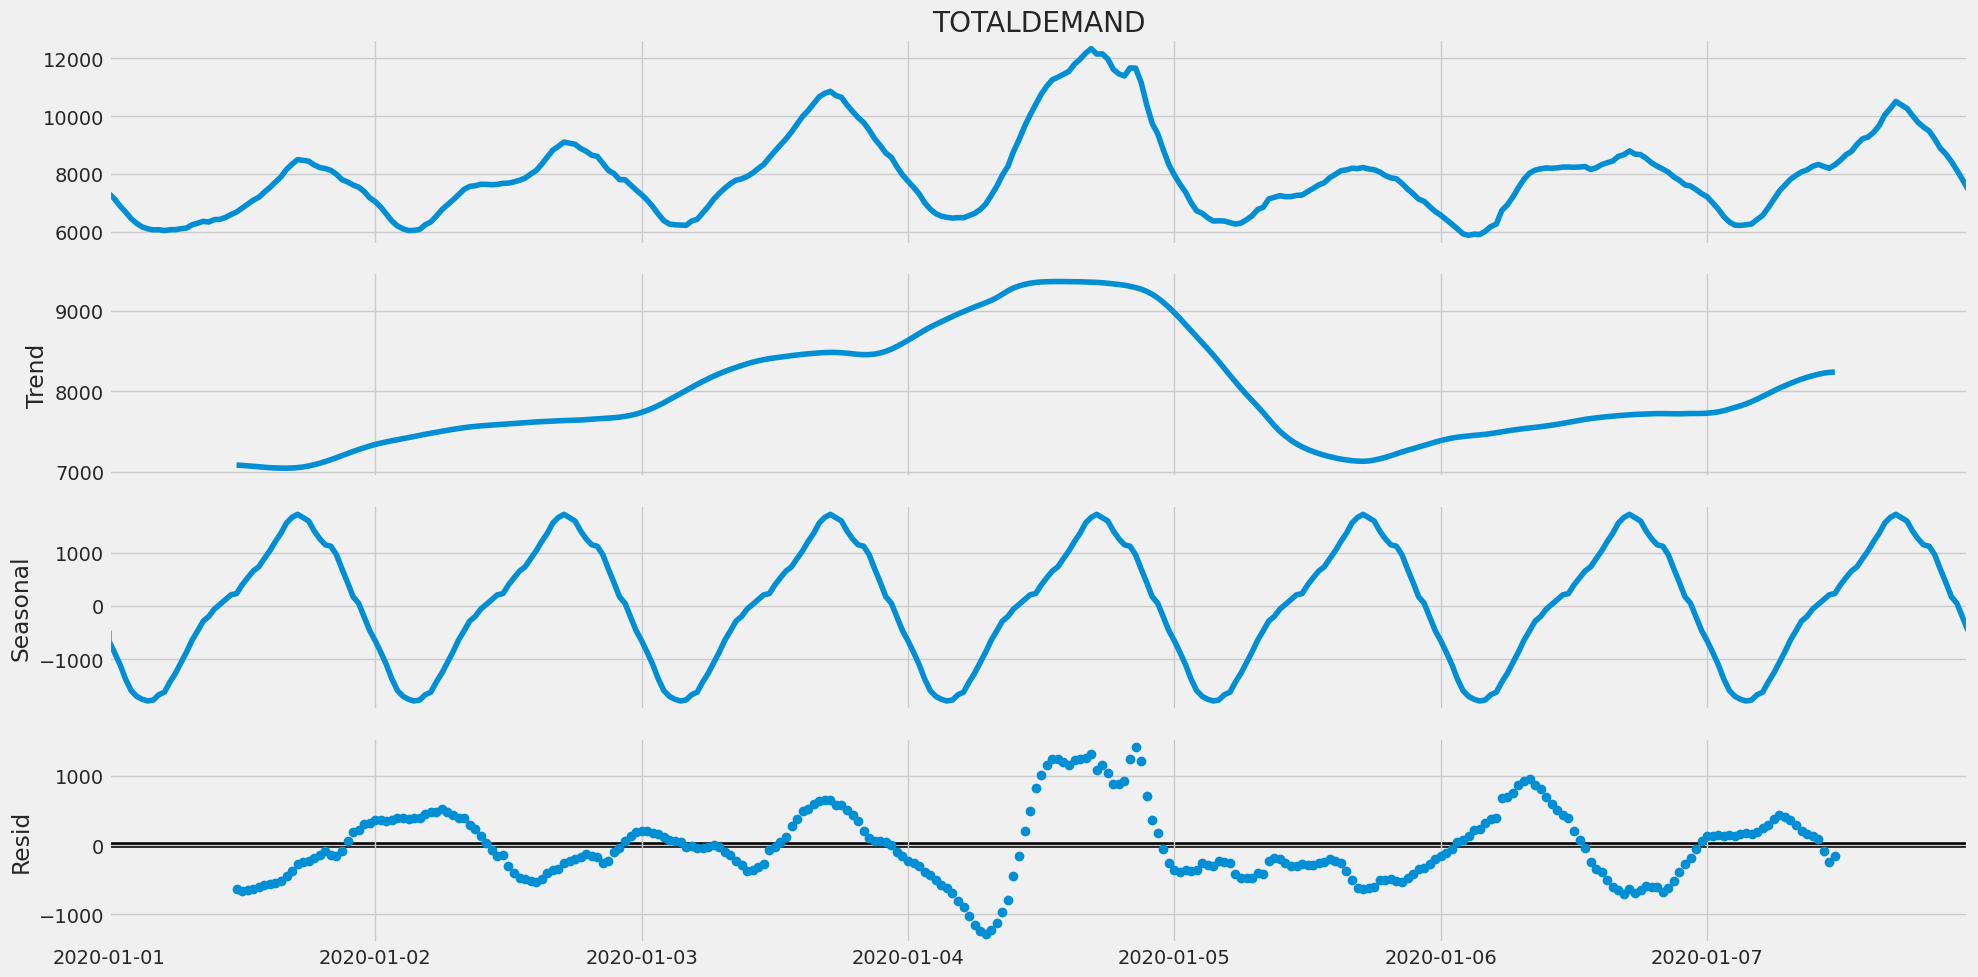

In [492]:
one_week_data = nsw_df['2020-01-01':'2020-01-07']
res_one_week = seasonal_decompose(
    one_week_data['TOTALDEMAND'], 
    model='additive', 
    period=48
)
res_one_week.plot()

### Decompose for 2 days

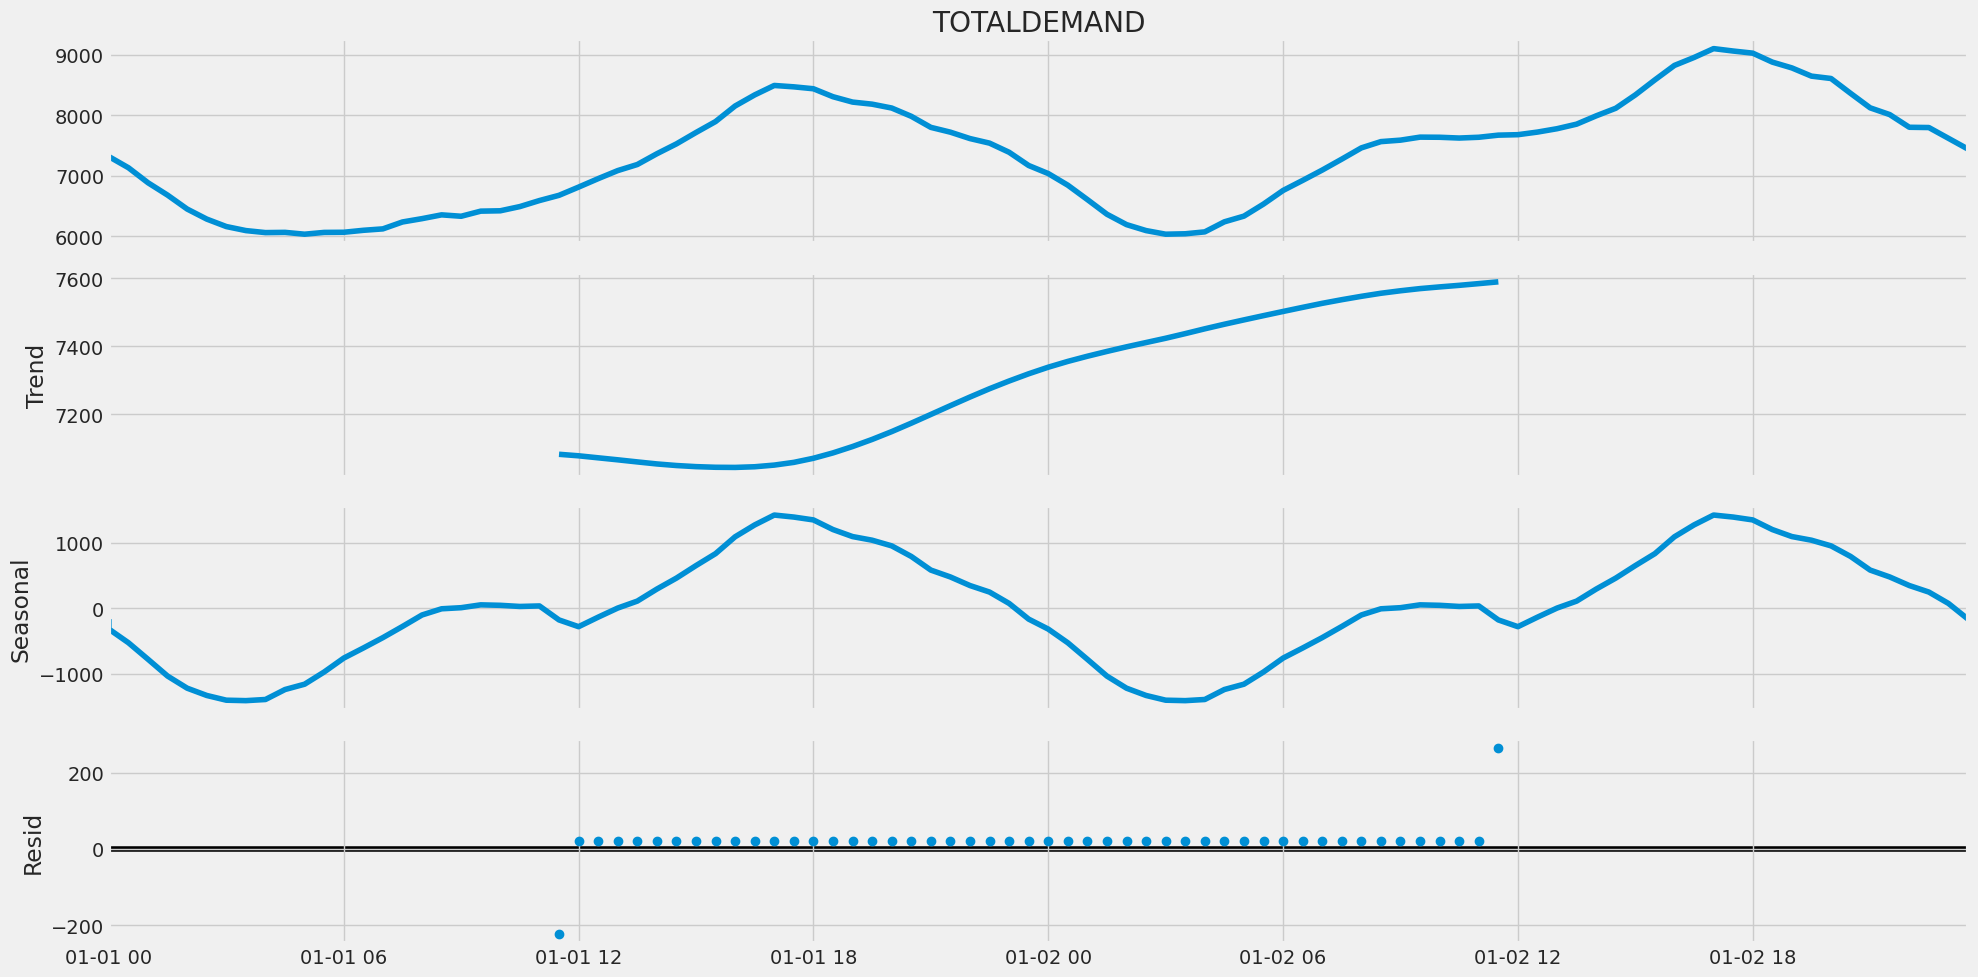

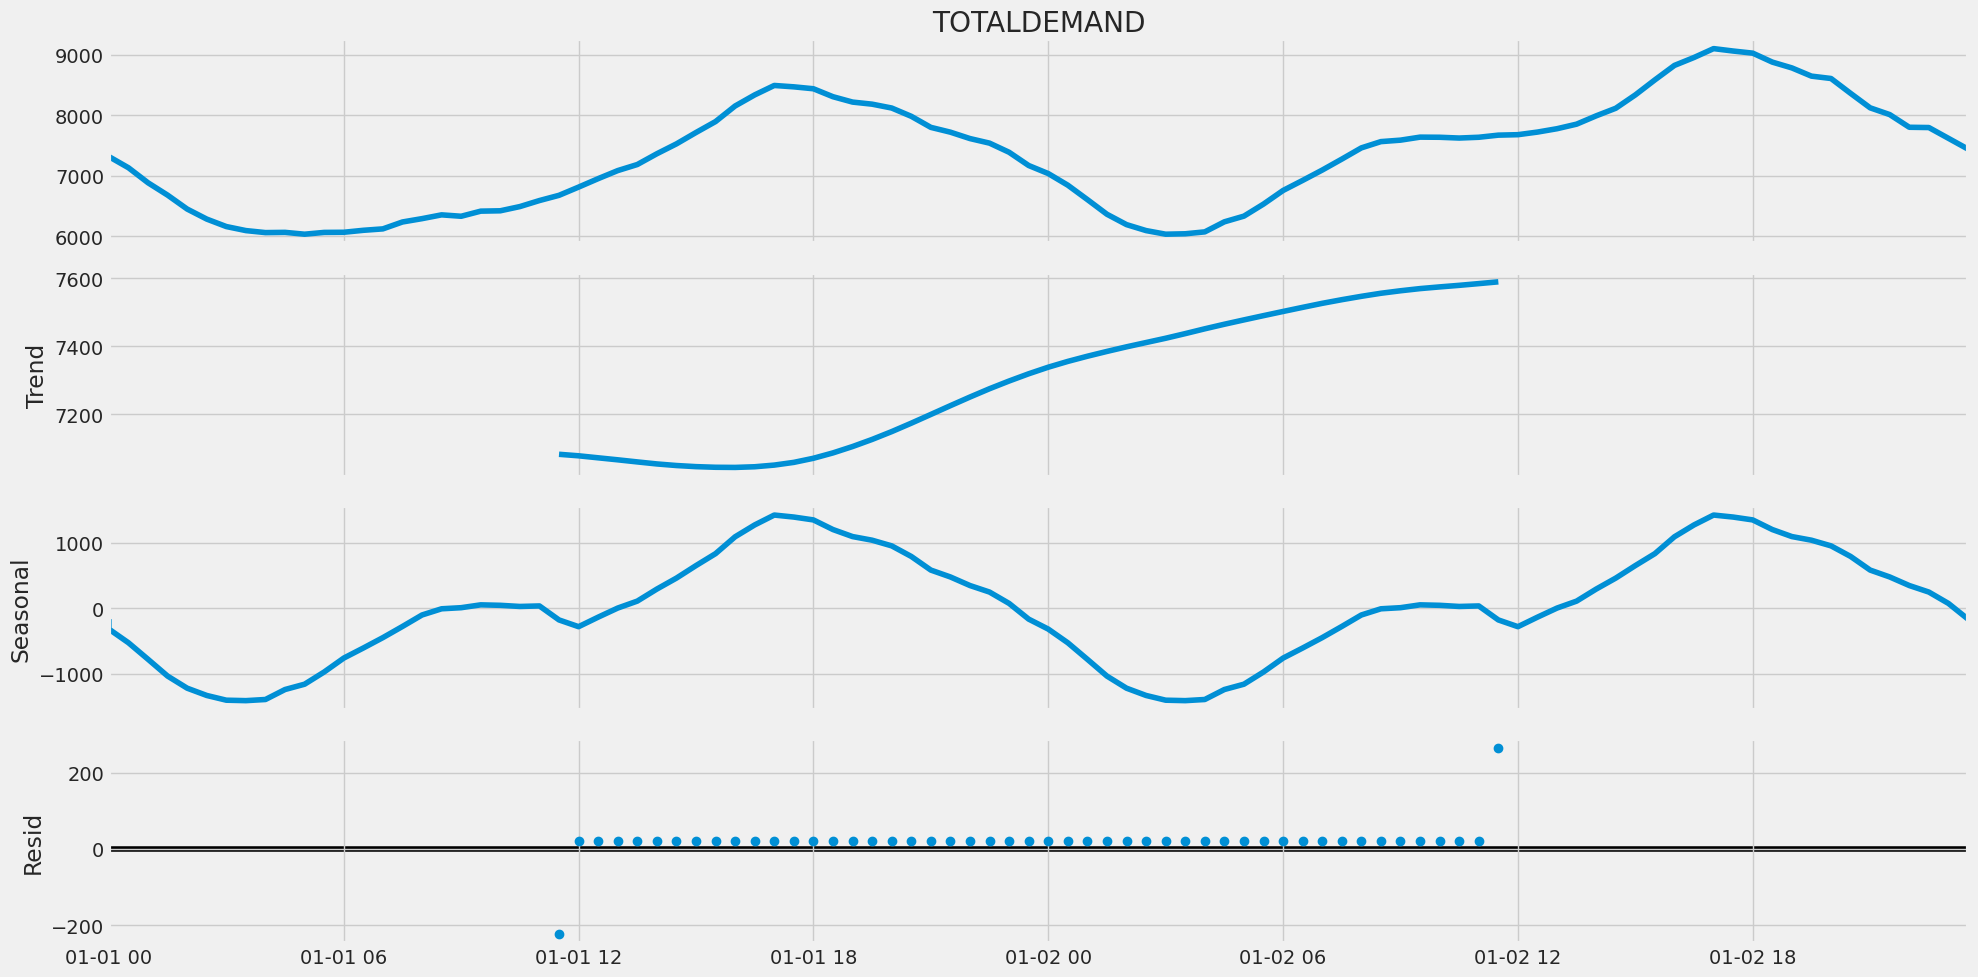

In [493]:
one_day_data = nsw_df['2020-01-01 00:00:00':'2020-01-02 23:30:00']
res_one_day = seasonal_decompose(
    one_day_data['TOTALDEMAND'], 
    model='additive',
    period=48
)
res_one_day.plot()

# Rolling statistics

# autocorrelation analysis (ACF and PACF)

# Day / Hour breakdwon

# How can we measure the current accuracy of the forecast demand vs actual demand?

# How can i do deocmposition, seasonality etc? Is that part of feature engineering or EDA?

# Data Cleaning

# Feature Engineering

# Model Selection & Development

# model tuning and evaluation

# insights and action